In [1]:
%load_ext autoreload
%autoreload 2

Try with **multiple dimension**! 5 or 6

In [2]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import numpy as np 
np.random.seed(42)
import pandas as pd
import os

In [3]:
from pathlib import Path
outfig_dir = os.path.join("output", "figures", "artificial")
Path(outfig_dir).mkdir(parents=True, exist_ok=True)

# Functions

In [4]:
def get_ranges_from_itemset(itemset):
    itemset_split = {}
    for item in itemset:
        
        if item=="":
            print(item)
            continue
        start_v, end_v = None, None
        s = item.split("=")
        attr, v = s[0], "=".join(s[1:])
        if v[0:2] == ">=":
            start_v = v[2:]
        elif v[0:2] == "<=":
            end_v = v[2:]
        else:
            v = v[1:-1]
            vals = v.split("-")
            if len(vals)==2:
                start_v, end_v = vals[0], vals[1]
            else:
                start_v, end_v = vals[0], vals[-1]
                if vals[0] == "":
                    start_v = "-" + vals[1]
                if vals[-2] == "":
                    end_v = "-" + vals[-1]
        itemset_split[attr] = float(start_v) if start_v!=None else start_v, float(end_v)  if end_v!=None else end_v
    return itemset_split

In [5]:
def show_splits_axes(attr, ax, ranges, min_max_vals, h = 2, eps=0, show_all_if_non = False):
    if attr not in ranges:
        if show_all_if_non:
            start_v, end_v = min_max_vals[attr][0], min_max_vals[attr][1]
            ax.axvspan(start_v, end_v, alpha=0.1)
            return ax
        else:
            print(f"Attribute {attr} not in the itemset")
            return ax
    start_v, end_v = ranges[attr]
    if start_v is None:
        start_v = min_max_vals[attr][0]
    if end_v is None:
        end_v = min_max_vals[attr][1]
    
    ax.axvspan(start_v, end_v, alpha=0.1)
    ax.hlines(y=h, xmin=start_v, xmax=end_v, linestyle = '--')
    ax.scatter([start_v + eps ], [h], marker = '<', c = "black" )
    ax.scatter([end_v - eps], [h], marker = '>' , c = "black" )
    return ax
        

In [6]:
def add_splits_axes(attr, ax, tree_discr, min_max_vals, g, cmap_type='tab10', show_span = True, show_lines = True, p = 0.2, eps = 0.1):

    splits = tree_discr.trees[attr].get_discretization_relations(apply_generalization=True, generalization_dict = generalization_dict)

    cmap=plt.get_cmap(cmap_type)
    levels = []
    for rel, value, level, rel_int, values_int in list(tree_discr.trees[attr].printTreeHierarchy()[['rel', 'value', 'level', 'rels_ret', 'vals_ret']].values):
        rel, value = list(rel)[0], list(value)[0]
        rel_int, values_int =  rel_int[attr], values_int[attr]

        ax.axvline(x=value, color = cmap(level), label = level, linestyle='-')
        levels.append(level)
        # Min and max values
        start_v, end_v= min_max_vals[attr][0], min_max_vals[attr][1]
       
        y = max(g)-max(g)*level*p
        if len(values_int) ==1:
            if rel_int[0] == '<=':
                end_v = values_int[0]
            else:
                start_v = values_int[0]
        else:
            start_v = values_int[0]
            end_v = values_int[1]

        if show_span:
            ax.axvspan(start_v, end_v, alpha=0.1, color = cmap(level))
        if show_lines:
            ax.hlines(y=y, xmin=start_v, xmax=end_v, color = cmap(level), linestyle = '--')
            ax.scatter([start_v + eps ], [y], marker = '<' , color = cmap(level))
            ax.scatter([end_v - eps], [y], marker = '>' , color = cmap(level))
    return ax, cmap, levels
        

In [7]:
def plot_normal_attr(x, ax, g_sc, g_attr_i, plot_points = False):
    if plot_points:
        ax.scatter(x, g_sc, s= 1, c="gray"); 
    ids = np.argsort(x)
    ax.plot(x[ids], g_attr_i[ids])
    return ax

In [8]:
def plot_attributes_split(df_vals, attributes, itemset, target_vals, g_attrs, min_max_vals, verbose = False, show_all_if_non = False, plot_points = False):
    
    ranges = get_ranges_from_itemset(itemset)
    if verbose:
        print("Ranges", ranges)
    eps = 0
    h = max(target_vals)+eps
    
    max_viz = 5
    if len(attributes)> max_viz:
        # Show at most max_viz attributes
        attributes = attributes[:max_viz]
    
    fig, axs = plt.subplots(1,len(attributes), figsize = (19,4))
    for e, attribute in enumerate(attributes):
        axs[e] = plot_normal_attr(df_vals[attribute].values, axs[e], target_vals, g_attrs[e], plot_points = plot_points)
        show_splits_axes(attribute, axs[e], ranges, min_max_vals, h, eps = eps, show_all_if_non = show_all_if_non)
        axs[e].set_title(attribute);
    return fig

In [9]:
def plot_attributes_split_gaussian(df_vals, attributes, itemset, target_vals, g_attrs, min_max_vals, \
        ylabel = None, wspace =.025, fontsize = 14, figsize = (9, 2.5), verbose = False, name_fig=None, save_fig = False, \
                                   show_all_if_non = False, plot_points = False):
    
    ranges = get_ranges_from_itemset(itemset)
    if verbose:
        print("Ranges", ranges)
    eps = 0
    h = max(target_vals)+eps
    
    max_viz = 5
    if len(attributes)> max_viz:
        # Show at most max_viz attributes
        attributes = attributes[:max_viz]
    
    fig, axs = plt.subplots(1,len(attributes), figsize =  figsize)
    for e, attribute in enumerate(attributes):
        axs[e] = plot_normal_attr(df_vals[attribute].values, axs[e], target_vals, g_attrs[e], plot_points = plot_points)
        show_splits_axes(attribute, axs[e], ranges, min_max_vals, h, eps = eps, show_all_if_non = show_all_if_non)
        axs[e].set_title(attribute, fontsize = fontsize)
        if e>0:
            axs[e].set_yticks([])
        for item in ([axs[e].title, axs[e].xaxis.label, axs[e].yaxis.label] +
                     axs[e].get_xticklabels() + axs[e].get_yticklabels()):
                item.set_fontsize(fontsize)
    plt.subplots_adjust(wspace = wspace)
    labels = {}
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        for id_l in range(0, len(l)):
            if l[id_l] not in labels:
                labels[l[id_l]] = h[id_l]
        

    if ylabel:
        axs[0].set_ylabel(ylabel)
    
    plt.tight_layout()
    if save_fig and name_fig:
        plt.savefig(name_fig);
    return fig

# Error rate based on a gaussian

In [10]:
stats_tree = {}

In [11]:
# Gaussian circolare
# Prodotto di 2 gaussiane
# Gaussian in 2 or n dimension
# Target function: try also weighted

# Points uniformely distributed in n dimensions (many!)
# Pick a point 
# Compute gaussian in that point exp -distance(p, centro)^2/sigma^2 (* coef of flipping, so that) ...
# Flip class with probability equal to the probabiliity indicated by the gaussian

(10000,)


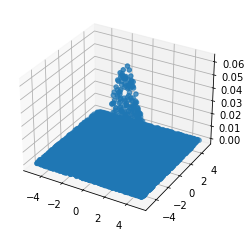

In [12]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
n = 10000
n_attributes = 3

#x = np.random.default_rng().uniform(-5,5,n)
#y = np.random.default_rng().uniform(-5,5,n)
#X = np.vstack([x,y]).T

X = np.random.uniform(low=-5, high=5, size=(n, n_attributes))

# g = norm(loc = 0., scale = 2.0).pdf(X)
mean = np.arange(n_attributes)
cov = np.ones(n_attributes)
#f_g = multivariate_normal(np.zeros(n_attributes), 0.1)
f_g = multivariate_normal(mean, cov)#, [1, 1, 1])
g = f_g.pdf(X)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1], g);
print(g.shape)

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
g_sc = np.round_(scaler.fit_transform(g.reshape(-1, 1))[:,0], 15)
print(min(g_sc), max(g_sc))

0.0 1.0


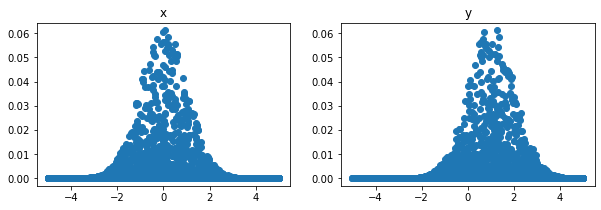

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.scatter(X[:,0], g); ax1.set_title("x"); 
ax2.scatter(X[:,1], g); ax2.set_title("y"); 

In [15]:
import string
attributes = list(string.ascii_lowercase)[:n_attributes]
attributes

['a', 'b', 'c']

In [16]:
g_attrs = []

for id_attr in range(X.shape[1]):
    g_attr = multivariate_normal.pdf(X[:,id_attr], mean=mean[id_attr], cov=cov[id_attr])
    g_attr_norm = scaler.fit_transform(g_attr.reshape(-1, 1))[:,0]
    g_attrs.append(g_attr_norm)

g_attrs = np.array(g_attrs)

In [17]:
# do not normalize drom 0 to 1, try less, 0.5?

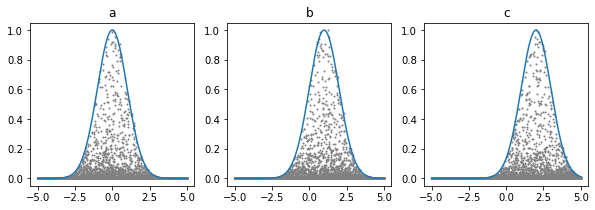

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

fig, axs = plt.subplots(1,X.shape[1], figsize = (10,3))

for id_attr in range(X.shape[1]):
    axs[id_attr].scatter(X[:,id_attr], g_sc, s= 1, c="gray"); 
    axs[id_attr].set_title(attributes[id_attr]); 
    ids = np.argsort(X[:,id_attr])
    axs[id_attr].plot(X[ids,id_attr], g_attrs[id_attr][ids])

In [19]:
classes = np.random.choice([0, 1], size=X.shape[0], p=[.5, .5])
opposed = 1 - classes

In [20]:
values = np.vstack((classes, opposed)).T

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
g_sc = np.round_(scaler.fit_transform(g.reshape(-1, 1))[:,0], 15)
print(min(g_sc), max(g_sc))

0.0 1.0


In [22]:
i = 0
np.random.choice(values[i:i+1][0], 1,
                          p = [1-g_sc[i], g_sc[i]])[0]


1

In [23]:
predicted_classes = [ np.random.choice(values[i:i+1][0], 1,
                          p = [1-g_sc[i], g_sc[i]])[0]
        for i in range(0, g_sc.shape[0]) ]
predicted_classes = np.asarray(predicted_classes)

In [24]:
print(X.shape)

np.hstack((X, np.vstack([classes, predicted_classes]).T))

(10000, 3)


array([[-1.25459881,  4.50714306,  2.31993942,  1.        ,  1.        ],
       [ 0.98658484, -3.4398136 , -3.4400548 ,  0.        ,  0.        ],
       [-4.41916388,  3.66176146,  1.01115012,  1.        ,  1.        ],
       ...,
       [ 2.77070991, -3.4174044 , -3.76695794,  0.        ,  0.        ],
       [-2.30683505,  4.5227545 ,  2.47824211,  0.        ,  0.        ],
       [-4.80544137, -0.98995158, -2.42602021,  0.        ,  0.        ]])

In [25]:
df_analysis = pd.DataFrame(np.hstack((X, classes.reshape(-1,1), predicted_classes.reshape(-1,1))), \
                           columns = attributes + ['true_class', 'predicted_class']).round(5)

In [26]:
df_analysis.head()

,a,b,c,true_class,predicted_class
0,-1.25460,4.50714,2.31994,1.0,1.0
1,0.98658,-3.43981,-3.44005,0.0,0.0
2,-4.41916,3.66176,1.01115,1.0,1.0
3,2.08073,-4.79416,4.69910,0.0,0.0
4,3.32443,-2.87661,-3.18175,1.0,1.0


In [27]:
min_max_vals = {attributes[e] : (min(X[:, 0]),max(X[:, 0])) for e in range(X.shape[1])}

In [28]:
pred_name ="predicted_class"
class_name =  "true_class" 
class_map={"P":1, "N":0}

## Tree divergence

In [29]:
min_support = 0.1
metric = "d_error"
#target = "n"
continuous_attributes = attributes

In [30]:
from tree_discretization import TreeDiscretization

tree_discr = TreeDiscretization()


type_experiment = "one_at_time"

type_criterion = "weighted_sum_abs_reference_s"


generalization_dict, discretizations = tree_discr.get_tree_discretization(
    df_analysis,
    type_splitting=type_experiment,
    min_support=0.1,
    metric=metric,
    continuous_attributes= list(continuous_attributes),
    storeTree=True,
    type_criterion = type_criterion,
    minimal_gain = 0.00,    
    class_map=class_map,
    class_and_pred_names=[class_name, pred_name],

    #target_col = target
)
tree_discr.printDiscretizationTrees(round_v =2)

dot = {}
for attribute in continuous_attributes:
    if attribute in tree_discr.trees:
        dot[attribute] = tree_discr.trees[attribute].visualizeTreeDiGraph(all_info=False)

a
 root s=1.00 --> d_error=0.00
         a<=1.76026 s=0.67 --> d_error=0.01
                 a<=-1.26817 s=0.37 --> d_error=-0.01
                         a<=-2.82237 s=0.21 --> d_error=-0.02
                                 a<=-3.88783 s=0.11 --> d_error=-0.02
                                 a>=-3.88431 s=0.10 --> d_error=-0.02
                         a>=-2.82109 s=0.15 --> d_error=-0.01
                 a>=-1.26793 s=0.31 --> d_error=0.03
                         a<=0.62862 s=0.19 --> d_error=0.04
                         a>=0.62917 s=0.11 --> d_error=0.01
         a>=1.76093 s=0.33 --> d_error=-0.01
                 a<=2.74722 s=0.10 --> d_error=-0.01
                 a>=2.74742 s=0.23 --> d_error=-0.02

b
 root s=1.00 --> d_error=0.00
         b<=-0.19441 s=0.48 --> d_error=-0.01
                 b<=-1.60971 s=0.34 --> d_error=-0.02
                 b>=-1.60924 s=0.14 --> d_error=-0.01
         b>=-0.19413 s=0.52 --> d_error=0.01
                 b<=2.36346 s=0.26 --> d_error=0.0

In [31]:
tree_discr.trees[attributes[0]].visualizeTreeDiGraph(all_info=False)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Plot ranges

In [32]:
attribute = attributes[0]

splits = tree_discr.trees[attribute].get_discretization_relations(apply_generalization=True, generalization_dict = generalization_dict)

In [33]:
plot_points = True

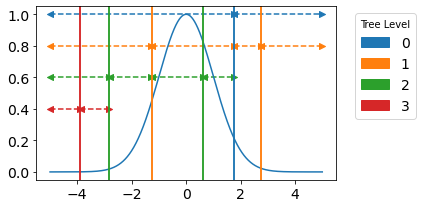

In [34]:
i = 0

attribute = attributes[i]

fig, ax = plt.subplots(figsize = (6,3))
# ax.scatter(X[:,i], g_sc, c="lightgray", s=1)
ax = plot_normal_attr(X[:,i], ax, g_sc, g_attrs[i], plot_points = False)


ax, cmap, levels = add_splits_axes( attribute, ax, tree_discr, min_max_vals, g_sc, eps = 0.01, show_span = False) #, show_lines=False)


import matplotlib.patches as mpatches

plt.legend(handles=[mpatches.Patch(color=cmap(level), label=level) for level in set(levels)], \
          title = "Tree Level", fontsize = 14, bbox_to_anchor=(1.04,1), loc="upper left") 

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
#plt.title(attribute);
plt.tight_layout()
plt.savefig(f"{outfig_dir}/artificial_gaussian_splits_attribute_{attribute}.pdf");

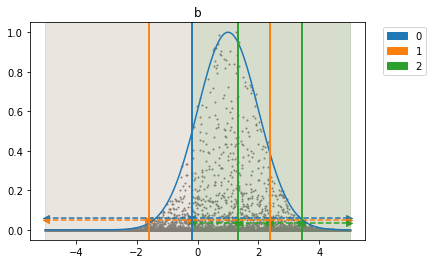

In [35]:
p =0.2
eps = 0.1

i = 1
attribute = attributes[i]

fig, ax = plt.subplots()
ax = plot_normal_attr(X[:,i], ax, g_sc, g_attrs[i], plot_points = plot_points)
ax, cmap, levels = add_splits_axes( attribute, ax, tree_discr, min_max_vals, g, eps = 0.01)


import matplotlib.patches as mpatches

plt.legend(handles=[mpatches.Patch(color=cmap(level), label=level) for level in set(levels)], \
          bbox_to_anchor=(1.04,1), loc="upper left");
plt.title(attribute);

In [36]:
tree_discr.printDiscretizationTrees(round_v=2)

a
 root s=1.00 --> d_error=0.00
         a<=1.76026 s=0.67 --> d_error=0.01
                 a<=-1.26817 s=0.37 --> d_error=-0.01
                         a<=-2.82237 s=0.21 --> d_error=-0.02
                                 a<=-3.88783 s=0.11 --> d_error=-0.02
                                 a>=-3.88431 s=0.10 --> d_error=-0.02
                         a>=-2.82109 s=0.15 --> d_error=-0.01
                 a>=-1.26793 s=0.31 --> d_error=0.03
                         a<=0.62862 s=0.19 --> d_error=0.04
                         a>=0.62917 s=0.11 --> d_error=0.01
         a>=1.76093 s=0.33 --> d_error=-0.01
                 a<=2.74722 s=0.10 --> d_error=-0.01
                 a>=2.74742 s=0.23 --> d_error=-0.02

b
 root s=1.00 --> d_error=0.00
         b<=-0.19441 s=0.48 --> d_error=-0.01
                 b<=-1.60971 s=0.34 --> d_error=-0.02
                 b>=-1.60924 s=0.14 --> d_error=-0.01
         b>=-0.19413 s=0.52 --> d_error=0.01
                 b<=2.36346 s=0.26 --> d_error=0.0

## Divergence 0.05

In [193]:
min_sup_divergence=0.05

### Without generalization

In [194]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)
apply_generalization = False

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=apply_generalization,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [195]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
6,0.1793,(c=[1.37391-3.1627]),855,55,55,828,1,1793.0,0.061350,0.044550,7.711696
4,0.1936,(a=[-1.26793-0.62862]),930,51,62,893,1,1936.0,0.058368,0.041568,7.627725
15,0.1017,(b=[1.34048-2.36346]),496,21,27,473,1,1017.0,0.047198,0.030398,4.572059
14,0.1104,(c=[0.29436-1.37354]),511,19,19,555,1,1104.0,0.034420,0.017620,3.226942


In [196]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [197]:
fpdiv.head(20)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
6,0.1793,(c=[1.37391-3.1627]),855,55,55,828,1,1793.0,0.061350,0.044550,7.711696
4,0.1936,(a=[-1.26793-0.62862]),930,51,62,893,1,1936.0,0.058368,0.041568,7.627725
15,0.1017,(b=[1.34048-2.36346]),496,21,27,473,1,1017.0,0.047198,0.030398,4.572059
14,0.1104,(c=[0.29436-1.37354]),511,19,19,555,1,1104.0,0.034420,0.017620,3.226942
12,0.1142,(a=[0.62917-1.76026]),556,20,11,555,1,1142.0,0.027145,0.010345,2.197269
0,1.0000,(),4917,85,83,4915,0,10000.0,0.016800,0.000000,0.000000
8,0.1548,(a=[-2.82109--1.26817]),744,11,6,787,1,1548.0,0.010982,-0.005818,1.755298
16,0.1000,(b=[2.36444-3.41615]),493,5,5,497,1,1000.0,0.010000,-0.006800,1.674987
11,0.1414,(b=[-1.60924--0.19441]),711,6,7,690,1,1414.0,0.009194,-0.007606,2.394572


In [198]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["base"] = fpdiv.iloc[0]

In [205]:
min_sup_divergence*len(df_analysis)

500.0

In [218]:
FP_fm.sort_values("error", ascending = False)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
6,0.1793,(c=[1.37391-3.1627]),855,55,55,828,1,1793.0,0.061350,0.044550,7.711696
4,0.1936,(a=[-1.26793-0.62862]),930,51,62,893,1,1936.0,0.058368,0.041568,7.627725
15,0.1017,(b=[1.34048-2.36346]),496,21,27,473,1,1017.0,0.047198,0.030398,4.572059
14,0.1104,(c=[0.29436-1.37354]),511,19,19,555,1,1104.0,0.034420,0.017620,3.226942
12,0.1142,(a=[0.62917-1.76026]),556,20,11,555,1,1142.0,0.027145,0.010345,2.197269
0,1.0000,(),4917,85,83,4915,0,10000.0,0.016800,0.000000,0.000000
8,0.1548,(a=[-2.82109--1.26817]),744,11,6,787,1,1548.0,0.010982,-0.005818,1.755298
16,0.1000,(b=[2.36444-3.41615]),493,5,5,497,1,1000.0,0.010000,-0.006800,1.674987
11,0.1414,(b=[-1.60924--0.19441]),711,6,7,690,1,1414.0,0.009194,-0.007606,2.394572


#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478


output/figures/artificial/artificial_gaussian_splits_sup_0.05_base.pdf
Attribute a not in the itemset
Attribute c not in the itemset


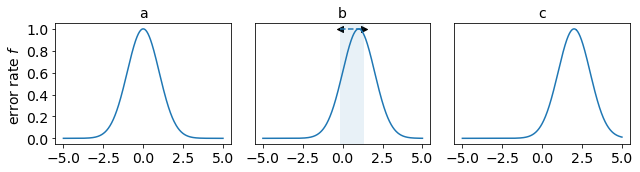

In [44]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
type_gen = 'generalized' if apply_generalization else "base"
name_fig = f"{outfig_dir}/artificial_gaussian_splits_sup_{min_sup_divergence}_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478


Attribute a not in the itemset
Attribute c not in the itemset


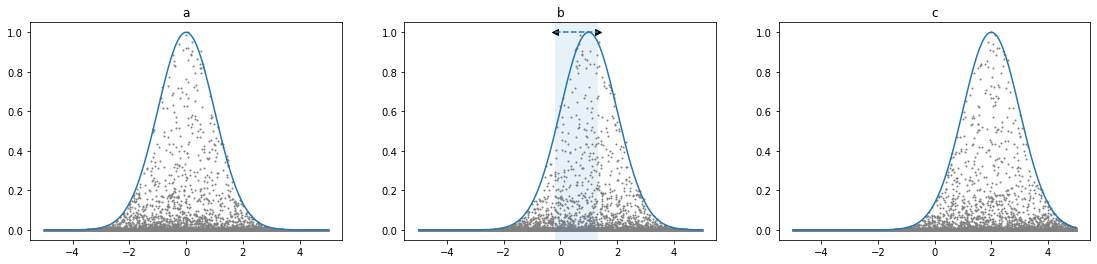

In [43]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, plot_points=plot_points);

In [45]:
s_cols = []
tvalue_col = "t_value_fp_fn"
cols_show = ["support", "itemsets", metric, tvalue_col]
pd.set_option("max_colwidth", None)
sh = fpdiv.iloc[i:i+3][cols_show]
sh[tvalue_col] = sh[tvalue_col].round(1)
sh["support"] = sh["support"].round(2)
sh[metric] = sh[metric].round(3)
sh

,support,itemsets,d_error,t_value_fp_fn
9,0.15,(b=[-0.19413-1.34037]),0.045,7.3
6,0.18,(c=[1.37391-3.1627]),0.045,7.7
4,0.19,(a=[-1.26793-0.62862]),0.042,7.6


### With generalization

In [46]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

apply_generalization = True

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=apply_generalization,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    #target_name = target,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [47]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
234,0.0505,"(c=[0.29436-3.1627], b=[-0.19413-2.36346], a=<=1.76026)",169,61,63,212,3,505.0,0.245545,0.228745,11.982265
218,0.0531,"(a=[-1.26793-0.62862], b=[-0.19413-2.36346])",226,43,56,206,2,531.0,0.186441,0.169641,10.075816
204,0.0550,"(a=[-1.26793-0.62862], c=[0.29436-3.1627])",241,42,57,210,2,550.0,0.180000,0.163200,9.998423
223,0.0523,"(c=[1.37391-3.1627], a=[-1.26793-1.76026])",237,44,50,192,2,523.0,0.179732,0.162932,9.744770
235,0.0502,"(c=>=0.29436, b=[-0.19413-1.34037], a=<=1.76026)",183,49,41,229,3,502.0,0.179283,0.162483,9.534390


In [48]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [52]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["generalized"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
234,0.0505,"(c=[0.29436-3.1627], b=[-0.19413-2.36346], a=<=1.76026)",169,61,63,212,3,505.0,0.245545,0.228745,11.982265


output/figures/artificial/artificial_gaussian_splits_sup_0.05_generalized.pdf


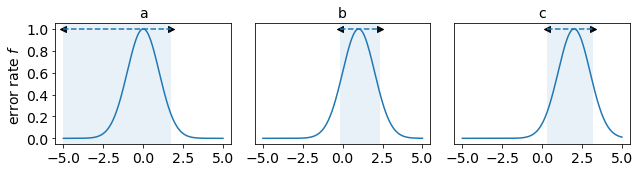

In [53]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
type_gen = 'generalized' if apply_generalization else "base"
name_fig = f"{outfig_dir}/artificial_gaussian_splits_sup_{min_sup_divergence}_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
218,0.0531,"(a=[-1.26793-0.62862], b=[-0.19413-2.36346])",226,43,56,206,2,531.0,0.186441,0.169641,10.075816


Attribute c not in the itemset


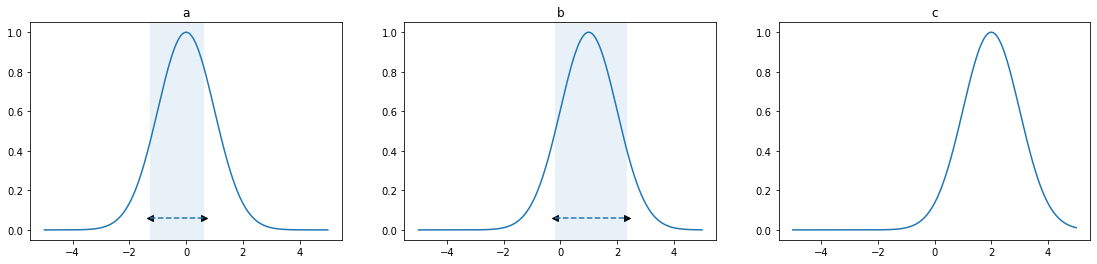

In [54]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g,g_attrs, min_max_vals);

In [55]:
errors = (df_analysis["true_class"]!=df_analysis["predicted_class"]).values.astype(int)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
218,0.0531,"(a=[-1.26793-0.62862], b=[-0.19413-2.36346])",226,43,56,206,2,531.0,0.186441,0.169641,10.075816


Attribute c not in the itemset


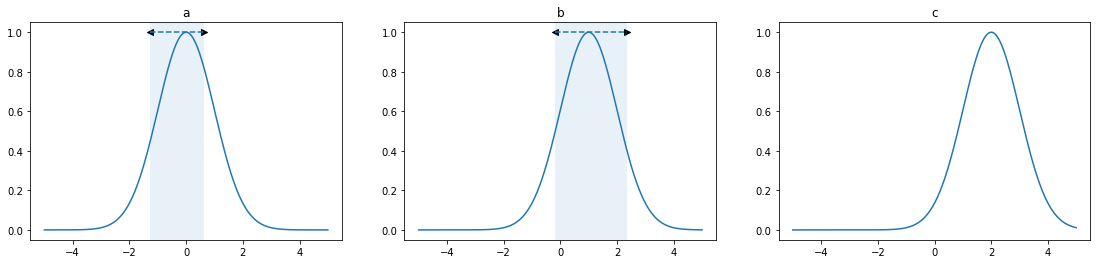

In [56]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g_sc, g_attrs, min_max_vals);

In [57]:
s_cols = []
tvalue_col = "t_value_fp_fn"
cols_show = ["support", "itemsets", metric, tvalue_col]
pd.set_option("max_colwidth", None)
sh = fpdiv.iloc[i:i+3][cols_show]
sh[tvalue_col] = sh[tvalue_col].round(1)
sh["support"] = sh["support"].round(2)
sh[metric] = sh[metric].round(3)
sh

,support,itemsets,d_error,t_value_fp_fn
218,0.05,"(a=[-1.26793-0.62862], b=[-0.19413-2.36346])",0.170,10.1
204,0.06,"(a=[-1.26793-0.62862], c=[0.29436-3.1627])",0.163,10.0
223,0.05,"(c=[1.37391-3.1627], a=[-1.26793-1.76026])",0.163,9.7


## SliceFinder

In [58]:
def getRecommendationsDf(recommendations, encoders = {}):
    recom_df=[]
    for s in recommendations:
        itemset=[]
        for k, v in list(s.filters.items()):
            values = ''
            if k in encoders:
                le = encoders[k]
                for v_ in v:
                    values += '%s'%(le.inverse_transform(v_)[0])
            else:
                for v_ in v:
                    values += '%s'%(v_[0])
            itemset.append(f"{k}={values}")

        recom_df.append([frozenset(itemset), s.effect_size, s.metric, s.size])
    recom_df=pd.DataFrame(recom_df, columns=["itemset", "effect_size", "metric", "size"])
    return recom_df

In [58]:
from utils_discretize_df import (
    discretize_df_via_discretizations,
)

df_discreted_d = discretize_df_via_discretizations(
    df_analysis,
    discretizations,
    allow_overalp = False
)

df_discreted_d

,a,b,c,true_class,predicted_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [60]:
from sklearn.metrics import log_loss
import functools

from sklearn.utils.multiclass import unique_labels
classes=unique_labels(df_discreted_d["true_class"].values)

y_p = list(map(functools.partial(np.expand_dims, axis=0), df_discreted_d["true_class"].values))
y = list(map(functools.partial(np.expand_dims, axis=0), df_discreted_d["predicted_class"].values))
loss_list_FP= np.array(list(map(functools.partial(log_loss, labels=classes), y, y_p)))

In [61]:
times_sf = {}
n_times = 1
import time

In [62]:
import sys
sys.path.append("./SliceFinder_master/")
from SliceFinder_master.slice_finder import SliceFinder

In [63]:
from pathlib import Path

Path("./log").mkdir(parents=True, exist_ok=True)

### Default effect size

In [64]:
max_workers=1

n_bin=10
degree=3
k=f"max_w_{max_workers}"
times_sf[k]={}

for i in range(0,n_times):
    s=time.time()
    sf = SliceFinder((df_discreted_d[continuous_attributes], df_discreted_d["true_class"]), n_bin, loss_list_FP)
    recommendations = sf.find_slice(degree=degree, max_workers=max_workers)
    times_sf[k][i]=time.time()-s
    print(round(time.time()-s,4))

degree 1
degree : 1, recommended slices : 4
degree 2
degree : 2, recommended slices : 1
degree 3
degree : 3, recommended slices : 0
3.5432


In [65]:
recom_df=getRecommendationsDf(recommendations)
print(len(recom_df), len(recom_df.drop_duplicates()))

recom_df=recom_df.drop_duplicates()
recom_df.sort_values("effect_size", ascending=False).head(10)

5 5


,itemset,effect_size,metric,size
1,(c=[1.37391-3.1627]),0.789122,2.118968,1793
2,(b=[-0.19413-1.34037]),0.768655,2.144737,1546
0,(a=[-1.26793-0.62862]),0.757545,2.015972,1936
4,"(a=[0.62917-1.76026], c=[0.29436-1.37354])",0.660683,2.238661,108
3,(b=[1.34048-2.36346]),0.491535,1.630165,1017


#### Top

,itemset,effect_size,metric,size
1,(c=[1.37391-3.1627]),0.789122,2.118968,1793


Attribute a not in the itemset
Attribute b not in the itemset


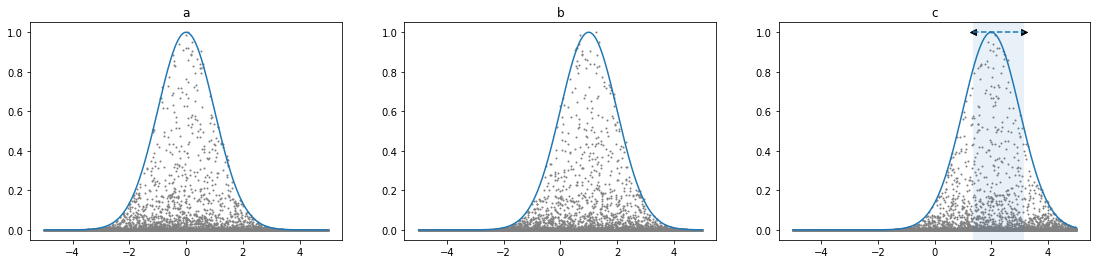

In [66]:
i = 0

recom_df_plot = recom_df.sort_values("effect_size", ascending=False)
display(recom_df_plot.iloc[i:i+1])

itemset = recom_df_plot.iloc[i]["itemset"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, plot_points=plot_points);

,itemset,effect_size,metric,size
1,(c=[1.37391-3.1627]),0.789122,2.118968,1793


output/figures/artificial/artificial_gaussian_splits_base_slice_finder.pdf
Attribute a not in the itemset
Attribute b not in the itemset


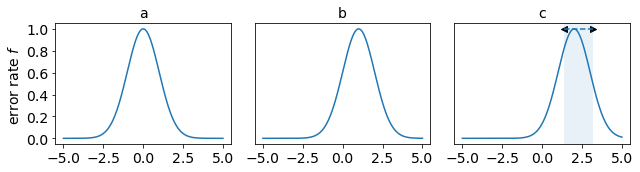

In [67]:
i = 0
recom_df_plot = recom_df.sort_values("effect_size", ascending=False)
display(recom_df_plot.iloc[i:i+1])

itemset = recom_df_plot.iloc[i]["itemset"]
type_gen = 'base_slice_finder' 
name_fig = f"{outfig_dir}/artificial_gaussian_splits_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);

### Greater effect size

In [68]:
max_workers=1

n_bin=20
degree=3
k=f"max_w_{max_workers}"
times_sf[k]={}


eps=1

for i in range(0,n_times):
    s=time.time()
    sf = SliceFinder((df_discreted_d[continuous_attributes], df_discreted_d["true_class"]), n_bin, loss_list_FP)
    recommendations = sf.find_slice(degree=degree, max_workers=max_workers, epsilon=eps, k = 50)
    times_sf[k][i]=time.time()-s
    print(round(time.time()-s,4))

degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 10
degree 3
degree : 3, recommended slices : 21
4.1232


In [69]:
recom_df=getRecommendationsDf(recommendations)
print(len(recom_df), len(recom_df.drop_duplicates()))

recom_df=recom_df.drop_duplicates()
recom_df.sort_values("effect_size", ascending=False).head(10)

31 21


,itemset,effect_size,metric,size
25,"(b=[1.34048-2.36346], a=[0.62917-1.76026], c=[0.29436-1.37354])",3.153968,10.627439,13
2,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",2.499060,7.915233,288
0,"(c=[1.37391-3.1627], a=[-1.26793-0.62862])",2.415299,7.581756,328
1,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",2.245155,7.037757,319
22,"(b=[1.34048-2.36346], c=[1.37391-3.1627], a=[0.62917-1.76026])",1.974310,6.476071,16
14,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-2.82109--1.26817])",1.811645,5.896962,41
27,"(b=[-0.19413-1.34037], a=[0.62917-1.76026], c=[0.29436-1.37354])",1.762467,5.756596,12
6,"(b=[1.34048-2.36346], c=[1.37391-3.1627])",1.758644,5.595726,179
4,"(b=[1.34048-2.36346], a=[-1.26793-0.62862])",1.750327,5.539287,212
10,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862], c=>=3.16338)",1.581824,5.116930,54


#### Top

,itemset,effect_size,metric,size
25,"(b=[1.34048-2.36346], a=[0.62917-1.76026], c=[0.29436-1.37354])",3.153968,10.627439,13


output/figures/artificial/artificial_gaussian_splits_base_slice_finder_eps_1.pdf


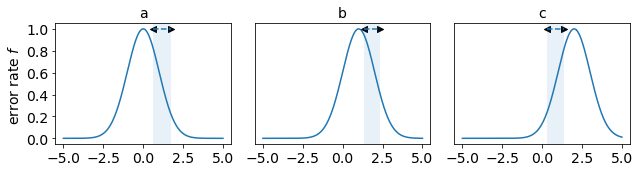

In [70]:
i = 0
recom_df_plot = recom_df.sort_values("effect_size", ascending=False)
display(recom_df_plot.iloc[i:i+1])

itemset = recom_df_plot.iloc[i]["itemset"]
type_gen = 'base_slice_finder' 
name_fig = f"{outfig_dir}/artificial_gaussian_splits_{type_gen}_eps_{eps}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals,\
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);

In [71]:
0.025*len(df_analysis)

250.0

,itemset,effect_size,metric,size
14,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-2.82109--1.26817])",1.811645,5.896962,41


output/figures/artificial/artificial_gaussian_splits_base_slice_finder_1.pdf


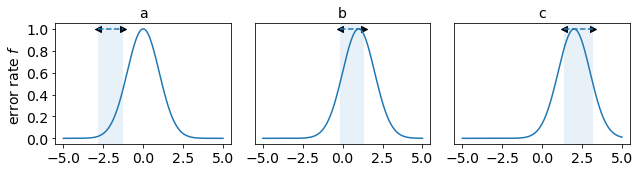

In [72]:
i = 5
recom_df_plot = recom_df.sort_values("effect_size", ascending=False)
display(recom_df_plot.iloc[i:i+1])

itemset = recom_df_plot.iloc[i]["itemset"]
type_gen = 'base_slice_finder' 
name_fig = f"{outfig_dir}/artificial_gaussian_splits_{type_gen}_{eps}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals,\
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = False);

## SliceLine

In [58]:
import sys
sys.path.append("./sliceline_master/")
from sliceline_master.sliceline.slicefinder import Slicefinder as SliceLine

In [59]:
from utils_discretize_df import (
    discretize_df_via_discretizations,
)

df_discreted_d = discretize_df_via_discretizations(
    df_analysis,
    discretizations,
    allow_overalp = False
)

In [62]:
X = df_discreted_d[continuous_attributes]

In [81]:
error_arr = (df_discreted_d[class_name]!=df_discreted_d[pred_name]).astype(int).values

In [232]:
def get_slice_line_error_rate(df_sl, df_discreted_d):
    error_rate = {}
    for i in range(len(df_sl)):
        itemset = frozenset([f"{k}={v}" for k, v in dict(df_sl.iloc[i]).items() if v!=None])
        indexes = df_discreted_d.index
        for item in itemset:

            av = item.split("=")
            attribute = av[0]
            v = "=".join(av[1:])
            indexes = df_discreted_d.loc[indexes].loc[df_discreted_d[attribute] == v].index
        sel = df_discreted_d.loc[indexes]
        err_sel = (sel[class_name]!=sel[pred_name]).astype(int)
        error_rate[i] = np.sum(err_sel)/len(err_sel)
    return error_rate

In [256]:
error_rate = {}

for min_sup_cnt in [500, 250]:
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        slice_line = SliceLine(min_sup=min_sup_cnt, alpha = alpha, max_l = 3, k=50, verbose = False)

        slice_line.fit(df_discreted_d[continuous_attributes], error_arr)

        df_sl = pd.DataFrame(slice_line.top_slices_, columns=slice_line.feature_names_in_, index=slice_line.get_feature_names_out())


        res = get_slice_line_error_rate(df_sl, df_discreted_d)
        if res:
            best = sorted(res.items(), key=lambda item: item[1], reverse = True)[0]
            itemset = frozenset([f"{k}={v}" for k, v in dict(df_sl.iloc[best[0]]).items() if v!=None])
            error_rate[alpha] = (best, itemset)
            
    print(error_rate)


{0.7: ((2, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})), 0.8: ((2, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})), 0.9: ((1, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})), 1: ((0, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'}))}
{0.7: ((2, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})), 0.8: ((1, 0.22916666666666666), frozenset({'c=[1.37391-3.1627]', 'b=[-0.19413-1.34037]'})), 0.9: ((0, 0.22916666666666666), frozenset({'c=[1.37391-3.1627]', 'b=[-0.19413-1.34037]'})), 1: ((0, 0.22916666666666666), frozenset({'c=[1.37391-3.1627]', 'b=[-0.19413-1.34037]'}))}


{0.7: ((2, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})),
 0.8: ((2, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})),
 0.9: ((1, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'})),
 1: ((0, 0.062095730918499355), frozenset({'b=[-0.19413-1.34037]'}))}

In [234]:
best = sorted(error_rate.items(), key=lambda item: item[1], reverse = True)[0]
error_rate

TypeError: '<' not supported between instances of 'dict' and 'dict'

frozenset({'b=[-0.19413-1.34037]'})
output/figures/artificial/artificial_gaussian_splits_base_slice_line.pdf
Attribute a not in the itemset
Attribute c not in the itemset


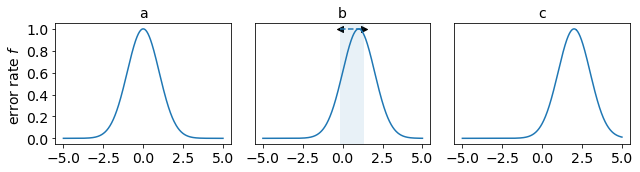

In [227]:
i = 2
itemset = frozenset([f"{k}={v}" for k, v in dict(df_sl.iloc[i]).items() if v!=None])
print(itemset)

type_gen = 'base_slice_line' 
name_fig = f"{outfig_dir}/artificial_gaussian_splits_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = False);

In [ ]:


X_trans = slice_finder.transform(X)

## Divergence 0.025

In [73]:
min_sup_divergence=0.025

### Without generalization

In [74]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)


apply_generalization = False

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=apply_generalization,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [75]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825
47,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483
49,0.0319,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",125,30,35,129,2,319.0,0.203762,0.186962,8.365233
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
6,0.1793,(c=[1.37391-3.1627]),855,55,55,828,1,1793.0,0.061350,0.044550,7.711696


In [76]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [77]:
fpdiv.head(20)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825
47,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483
49,0.0319,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",125,30,35,129,2,319.0,0.203762,0.186962,8.365233
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
6,0.1793,(c=[1.37391-3.1627]),855,55,55,828,1,1793.0,0.061350,0.044550,7.711696
4,0.1936,(a=[-1.26793-0.62862]),930,51,62,893,1,1936.0,0.058368,0.041568,7.627725
15,0.1017,(b=[1.34048-2.36346]),496,21,27,473,1,1017.0,0.047198,0.030398,4.572059
57,0.0279,"(a=[-2.82109--1.26817], c=[1.37391-3.1627])",130,9,2,138,2,279.0,0.039427,0.022627,2.131303
14,0.1104,(c=[0.29436-1.37354]),511,19,19,555,1,1104.0,0.034420,0.017620,3.226942
54,0.0293,"(b=[-0.19413-1.34037], c=>=3.16338)",123,6,4,160,2,293.0,0.034130,0.017330,1.839114


In [78]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["base"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825


output/figures/artificial/artificial_gaussian_splits_sup_0.025_base.pdf
Attribute a not in the itemset


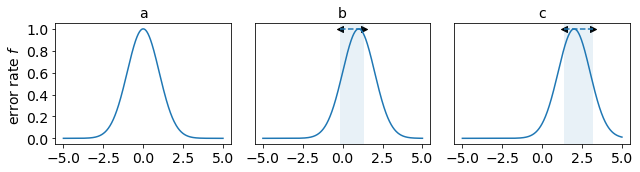

In [79]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
type_gen = 'generalized' if apply_generalization else "base"
name_fig = f"{outfig_dir}/artificial_gaussian_splits_sup_{min_sup_divergence}_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);


### With generalization

In [80]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)
apply_generalization = True
FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=apply_generalization,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    #target_name = target,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [81]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
304,0.0385,"(c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])",133,57,64,131,3,385.0,0.314286,0.297486,12.629937
390,0.0293,"(b=>=-0.19413, c=[0.29436-3.1627], a=[-1.26793-0.62862])",113,38,53,89,3,293.0,0.310580,0.293780,10.942177
410,0.0281,"(a=[-1.26793-1.76026], b=>=-0.19413, c=[1.37391-3.1627])",109,40,47,85,3,281.0,0.309609,0.292809,10.694037
365,0.0315,"(a=<=1.76026, c=[1.37391-3.1627], b=[-0.19413-2.36346])",98,47,46,124,3,315.0,0.295238,0.278438,10.904265
271,0.0447,"(a=[-1.26793-1.76026], b=>=-0.19413, c=[0.29436-3.1627])",181,56,63,147,3,447.0,0.266219,0.249419,11.978676


In [82]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [83]:
fp_divergence_o.getDivergence(th_redundancy=0).sort_values("length")

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
0,1.0000,(),4917,85,83,4915,0,10000.0,0.016800,0.000000,0.000000
10,0.3404,(b=<=-1.60971),1723,0,0,1681,1,3404.0,0.000000,-0.016800,12.562323
11,0.3252,(a=>=1.76093),1607,2,4,1639,1,3252.0,0.001845,-0.014955,9.680671
50,0.1548,(a=[-2.82109--1.26817]),744,11,6,787,1,1548.0,0.010982,-0.005818,1.755298
3,0.5182,(b=>=-0.19413),2483,79,76,2544,1,5182.0,0.029911,0.013111,4.887483
...,...,...,...,...,...,...,...,...,...,...,...
224,0.0521,"(c=<=0.2919, b=[-0.19413-1.34037], a=<=1.76026)",246,2,2,271,3,521.0,0.007678,-0.009122,1.651616
430,0.0270,"(b=[-1.60924--0.19441], a=<=-1.26817, c=>=0.29436)",140,0,2,128,3,270.0,0.007407,-0.009393,0.909499
53,0.1513,"(b=<=-0.19441, a=<=1.76026, c=>=0.29436)",754,5,6,748,3,1513.0,0.007270,-0.009530,3.430984
107,0.0948,"(b=<=-0.19441, a=<=1.76026, c=[0.29436-3.1627])",461,5,5,477,3,948.0,0.010549,-0.006251,1.436937


In [84]:
print("Mean error", fpdiv.loc[0]["error"].round(7))
fpdiv_t

Mean error 0.0168


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
304,0.0385,"(c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])",133,57,64,131,3,385.0,0.314286,0.297486,12.629937
390,0.0293,"(b=>=-0.19413, c=[0.29436-3.1627], a=[-1.26793-0.62862])",113,38,53,89,3,293.0,0.310580,0.293780,10.942177
410,0.0281,"(a=[-1.26793-1.76026], b=>=-0.19413, c=[1.37391-3.1627])",109,40,47,85,3,281.0,0.309609,0.292809,10.694037
365,0.0315,"(a=<=1.76026, c=[1.37391-3.1627], b=[-0.19413-2.36346])",98,47,46,124,3,315.0,0.295238,0.278438,10.904265
271,0.0447,"(a=[-1.26793-1.76026], b=>=-0.19413, c=[0.29436-3.1627])",181,56,63,147,3,447.0,0.266219,0.249419,11.978676
...,...,...,...,...,...,...,...,...,...,...,...
111,0.0922,"(a=<=-1.26817, b=>=2.36444)",480,0,0,442,2,922.0,0.000000,-0.016800,9.401748
76,0.1122,(a=<=-3.88783),587,0,0,535,1,1122.0,0.000000,-0.016800,10.224921
24,0.2252,(a=>=2.74742),1115,0,0,1137,1,2252.0,0.000000,-0.016800,12.072762
6,0.4310,(c=<=-0.71354),2181,0,0,2129,1,4310.0,0.000000,-0.016800,12.727562


In [85]:
fpdiv.head(10)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
304,0.0385,"(c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])",133,57,64,131,3,385.0,0.314286,0.297486,12.629937
390,0.0293,"(b=>=-0.19413, c=[0.29436-3.1627], a=[-1.26793-0.62862])",113,38,53,89,3,293.0,0.310580,0.293780,10.942177
410,0.0281,"(a=[-1.26793-1.76026], b=>=-0.19413, c=[1.37391-3.1627])",109,40,47,85,3,281.0,0.309609,0.292809,10.694037
365,0.0315,"(a=<=1.76026, c=[1.37391-3.1627], b=[-0.19413-2.36346])",98,47,46,124,3,315.0,0.295238,0.278438,10.904265
271,0.0447,"(a=[-1.26793-1.76026], b=>=-0.19413, c=[0.29436-3.1627])",181,56,63,147,3,447.0,0.266219,0.249419,11.978676
377,0.0306,"(b=[-0.19413-1.34037], a=<=1.76026, c=[0.29436-3.1627])",103,43,37,123,3,306.0,0.261438,0.244638,9.812848
234,0.0505,"(a=<=1.76026, c=[0.29436-3.1627], b=[-0.19413-2.36346])",169,61,63,212,3,505.0,0.245545,0.228745,11.982265
395,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825
346,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483
359,0.0319,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",125,30,35,129,2,319.0,0.203762,0.186962,8.365233


In [86]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["generalized"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
304,0.0385,"(c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])",133,57,64,131,3,385.0,0.314286,0.297486,12.629937


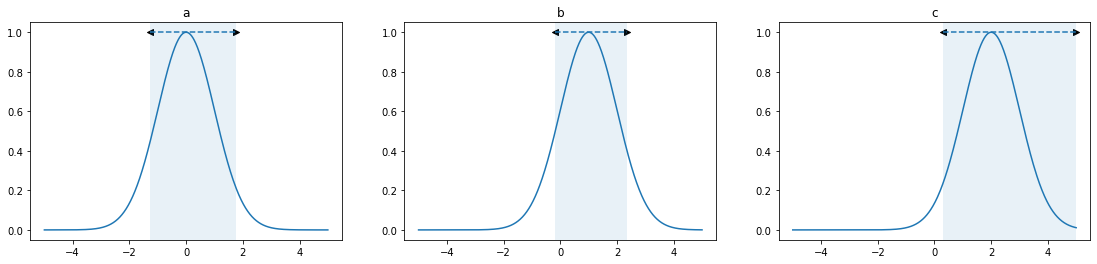

In [87]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals);

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
390,0.0293,"(b=>=-0.19413, c=[0.29436-3.1627], a=[-1.26793-0.62862])",113,38,53,89,3,293.0,0.31058,0.29378,10.942177


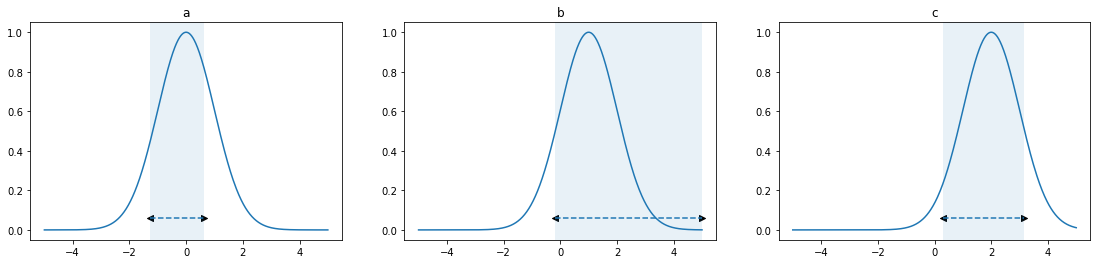

In [88]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g, g_attrs, min_max_vals);

## Divergence 0.01

In [89]:
min_sup_divergence=0.01

### Without generalization

In [90]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

apply_generalization = False

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=apply_generalization,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [91]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825
47,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483
49,0.0319,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",125,30,35,129,2,319.0,0.203762,0.186962,8.365233
87,0.0179,"(b=[1.34048-2.36346], c=[1.37391-3.1627])",67,13,16,83,2,179.0,0.162011,0.145211,5.394332
72,0.0212,"(b=[1.34048-2.36346], a=[-1.26793-0.62862])",101,13,21,77,2,212.0,0.160377,0.143577,5.806343


In [92]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [93]:
fpdiv.head(20)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825
47,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483
49,0.0319,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",125,30,35,129,2,319.0,0.203762,0.186962,8.365233
87,0.0179,"(b=[1.34048-2.36346], c=[1.37391-3.1627])",67,13,16,83,2,179.0,0.162011,0.145211,5.394332
72,0.0212,"(b=[1.34048-2.36346], a=[-1.26793-0.62862])",101,13,21,77,2,212.0,0.160377,0.143577,5.806343
132,0.0104,"(c=[0.29436-1.37354], b=[1.34048-2.36346])",37,5,10,52,2,104.0,0.144231,0.127431,3.870544
68,0.0222,"(c=[0.29436-1.37354], a=[-1.26793-0.62862])",97,12,15,98,2,222.0,0.121622,0.104822,4.894755
79,0.0195,"(a=[0.62917-1.76026], c=[1.37391-3.1627])",93,14,8,80,2,195.0,0.112821,0.096021,4.368550
101,0.0162,"(a=[0.62917-1.76026], b=[-0.19413-1.34037])",71,13,5,73,2,162.0,0.111111,0.094311,3.966355
104,0.0160,"(c=[0.29436-1.37354], b=[-0.19413-1.34037])",62,9,7,82,2,160.0,0.100000,0.083200,3.662382


In [94]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["base"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825


Attribute a not in the itemset


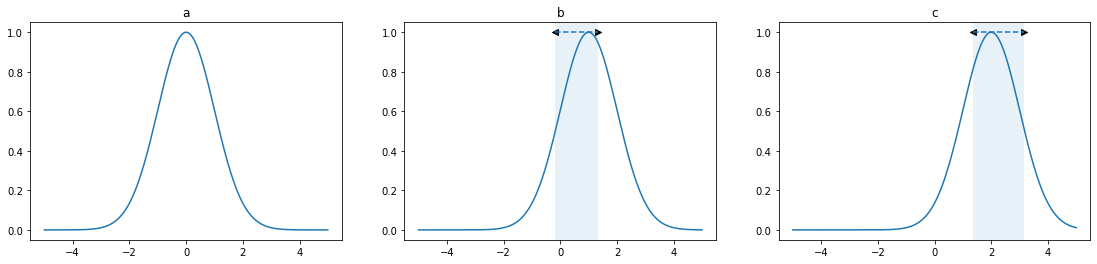

In [95]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals);

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
47,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483


Attribute b not in the itemset


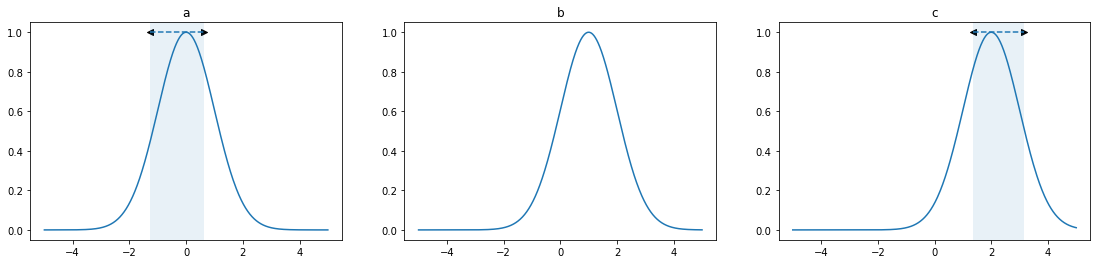

In [96]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals);

In [97]:
s_cols = []
tvalue_col = "t_value_fp_fn"
cols_show = ["support", "itemsets", metric, tvalue_col]
pd.set_option("max_colwidth", None)
sh = fpdiv.iloc[i:i+3][cols_show]
sh[tvalue_col] = sh[tvalue_col].round(1)
sh["support"] = sh["support"].round(2)
sh[metric] = sh[metric].round(3)
sh

,support,itemsets,d_error,t_value_fp_fn
47,0.03,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",0.203,8.9
49,0.03,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",0.187,8.4
87,0.02,"(b=[1.34048-2.36346], c=[1.37391-3.1627])",0.145,5.4


### With generalization

In [98]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)
apply_generalization = True

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=True,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    #target_name = target,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [99]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
673,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731
629,0.0158,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",37,34,51,36,3,158.0,0.537975,0.521175,13.241629
669,0.0144,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[0.29436-3.1627])",45,36,35,28,3,144.0,0.493056,0.476256,11.543995
477,0.0232,"(a=[-1.26793-1.76026], c=[0.29436-3.1627], b=[-0.19413-2.36346])",67,50,60,55,3,232.0,0.474138,0.457338,14.033032
643,0.0153,"(b=[-0.19413-1.34037], c=>=0.29436, a=[-1.26793-0.62862])",47,28,33,45,3,153.0,0.398693,0.381893,9.761991


In [100]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [101]:
fp_divergence_o.getDivergence(th_redundancy=0).sort_values("length")

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
0,1.0000,(),4917,85,83,4915,0,10000.0,0.016800,0.000000,0.000000
96,0.1000,(a=[-3.88431--2.82237]),493,1,0,506,1,1000.0,0.001000,-0.015800,7.802887
15,0.2897,(c=[0.29436-3.1627]),1366,74,74,1383,1,2897.0,0.051087,0.034287,8.027083
23,0.2252,(a=>=2.74742),1115,0,0,1137,1,2252.0,0.000000,-0.016800,12.072762
35,0.1793,(c=>=3.16338),880,8,7,898,1,1793.0,0.008366,-0.008434,3.112221
...,...,...,...,...,...,...,...,...,...,...,...
743,0.0116,"(a=[0.62917-1.76026], b=>=-0.19413, c=>=3.16338)",51,1,1,63,3,116.0,0.017241,0.000441,0.588603
231,0.0514,"(a=<=1.76026, c=[0.29436-3.1627], b=>=2.36444)",284,6,3,221,3,514.0,0.017510,0.000710,0.400628
406,0.0283,"(a=[-1.26793-0.62862], c=<=0.2919, b=[-0.19413-2.36346])",149,3,2,129,3,283.0,0.017668,0.000868,0.484038
196,0.0562,"(b=<=-0.19441, a=<=1.76026, c=[1.37391-3.1627])",282,4,3,273,3,562.0,0.012456,-0.004344,0.527769


In [102]:
print("Mean error", fpdiv.loc[0]["error"].round(7))
fpdiv_t

Mean error 0.0168


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
673,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731
629,0.0158,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",37,34,51,36,3,158.0,0.537975,0.521175,13.241629
669,0.0144,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[0.29436-3.1627])",45,36,35,28,3,144.0,0.493056,0.476256,11.543995
477,0.0232,"(a=[-1.26793-1.76026], c=[0.29436-3.1627], b=[-0.19413-2.36346])",67,50,60,55,3,232.0,0.474138,0.457338,14.033032
643,0.0153,"(b=[-0.19413-1.34037], c=>=0.29436, a=[-1.26793-0.62862])",47,28,33,45,3,153.0,0.398693,0.381893,9.761991
...,...,...,...,...,...,...,...,...,...,...,...
77,0.1122,(a=<=-3.88783),587,0,0,535,1,1122.0,0.000000,-0.016800,10.224921
23,0.2252,(a=>=2.74742),1115,0,0,1137,1,2252.0,0.000000,-0.016800,12.072762
10,0.3404,(b=<=-1.60971),1723,0,0,1681,1,3404.0,0.000000,-0.016800,12.562323
6,0.4310,(c=<=-0.71354),2181,0,0,2129,1,4310.0,0.000000,-0.016800,12.727562


In [103]:
fpdiv.head(10)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
673,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731
629,0.0158,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",37,34,51,36,3,158.0,0.537975,0.521175,13.241629
669,0.0144,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[0.29436-3.1627])",45,36,35,28,3,144.0,0.493056,0.476256,11.543995
477,0.0232,"(a=[-1.26793-1.76026], c=[0.29436-3.1627], b=[-0.19413-2.36346])",67,50,60,55,3,232.0,0.474138,0.457338,14.033032
643,0.0153,"(b=[-0.19413-1.34037], c=>=0.29436, a=[-1.26793-0.62862])",47,28,33,45,3,153.0,0.398693,0.381893,9.761991
455,0.0248,"(a=[-1.26793-0.62862], c=>=0.29436, b=[-0.19413-2.36346])",77,40,54,77,3,248.0,0.379032,0.362232,11.841199
558,0.0181,"(a=[-1.26793-0.62862], b=>=-0.19413, c=[1.37391-3.1627])",67,27,39,48,3,181.0,0.364641,0.347841,9.826786
543,0.0192,"(b=[-0.19413-1.34037], a=<=1.76026, c=[1.37391-3.1627])",58,34,30,70,3,192.0,0.333333,0.316533,9.405692
468,0.0239,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=>=0.29436)",81,41,38,79,3,239.0,0.330544,0.313744,10.398198
305,0.0385,"(c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])",133,57,64,131,3,385.0,0.314286,0.297486,12.629937


In [104]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["generalized"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
673,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731


output/figures/artificial/artificial_gaussian_splits_sup_0.01_generalized.pdf


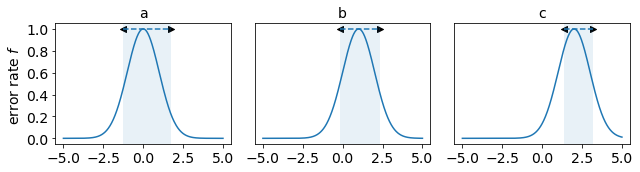

In [105]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
type_gen = 'generalized' if apply_generalization else "base"
name_fig = f"{outfig_dir}/artificial_gaussian_splits_sup_{min_sup_divergence}_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
629,0.0158,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",37,34,51,36,3,158.0,0.537975,0.521175,13.241629


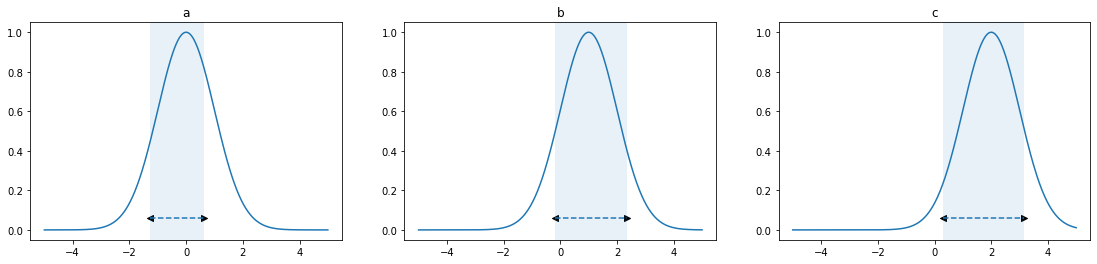

In [106]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g, g_attrs, min_max_vals);

In [107]:
errors = (df_analysis["true_class"]!=df_analysis["predicted_class"]).values.astype(int)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
629,0.0158,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",37,34,51,36,3,158.0,0.537975,0.521175,13.241629


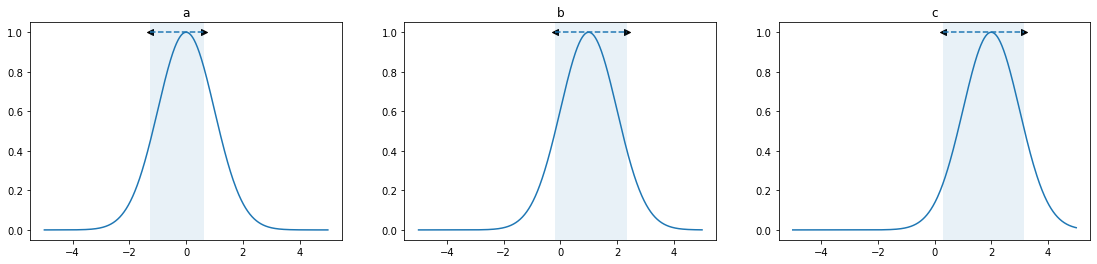

In [108]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g_sc, g_attrs, min_max_vals);

In [109]:
s_cols = []
tvalue_col = "t_value_fp_fn"
cols_show = ["support", "itemsets", metric, tvalue_col]
pd.set_option("max_colwidth", None)
sh = fpdiv.iloc[i:i+3][cols_show]
sh[tvalue_col] = sh[tvalue_col].round(1)
sh["support"] = sh["support"].round(2)
sh[metric] = sh[metric].round(3)
sh

,support,itemsets,d_error,t_value_fp_fn
629,0.02,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",0.521,13.2
669,0.01,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[0.29436-3.1627])",0.476,11.5
477,0.02,"(a=[-1.26793-1.76026], c=[0.29436-3.1627], b=[-0.19413-2.36346])",0.457,14.0


## Divergence 0.001

In [110]:
min_sup_divergence=0.001

### Without generalization

In [111]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)

apply_generalization = False

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=apply_generalization,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [112]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
180,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885
227,0.0035,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",6,8,14,7,3,35.0,0.628571,0.611771,7.685378
238,0.0033,"(a=[0.62917-1.76026], b=[-0.19413-1.34037], c=[1.37391-3.1627])",13,11,5,4,3,33.0,0.484848,0.468048,5.627436
264,0.0024,"(c=[0.29436-1.37354], b=[1.34048-2.36346], a=[-1.26793-0.62862])",6,3,7,8,3,24.0,0.416667,0.399867,4.271616
212,0.0040,"(c=[0.29436-1.37354], b=[-0.19413-1.34037], a=[-1.26793-0.62862])",16,6,7,11,3,40.0,0.325000,0.308200,4.401063


In [113]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [114]:
fpdiv.head(20)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
180,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885
227,0.0035,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",6,8,14,7,3,35.0,0.628571,0.611771,7.685378
238,0.0033,"(a=[0.62917-1.76026], b=[-0.19413-1.34037], c=[1.37391-3.1627])",13,11,5,4,3,33.0,0.484848,0.468048,5.627436
264,0.0024,"(c=[0.29436-1.37354], b=[1.34048-2.36346], a=[-1.26793-0.62862])",6,3,7,8,3,24.0,0.416667,0.399867,4.271616
212,0.0040,"(c=[0.29436-1.37354], b=[-0.19413-1.34037], a=[-1.26793-0.62862])",16,6,7,11,3,40.0,0.325000,0.308200,4.401063
315,0.0013,"(a=[0.62917-1.76026], c=[0.29436-1.37354], b=[1.34048-2.36346])",3,2,2,6,3,13.0,0.307692,0.290892,2.684894
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825
47,0.0328,"(a=[-1.26793-0.62862], c=[1.37391-3.1627])",144,30,42,112,2,328.0,0.219512,0.202712,8.941483
49,0.0319,"(b=[-0.19413-1.34037], a=[-1.26793-0.62862])",125,30,35,129,2,319.0,0.203762,0.186962,8.365233
305,0.0016,"(a=[0.62917-1.76026], b=[1.34048-2.36346], c=[1.37391-3.1627])",7,1,2,6,3,16.0,0.187500,0.170700,2.152577


In [115]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["base"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
180,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885


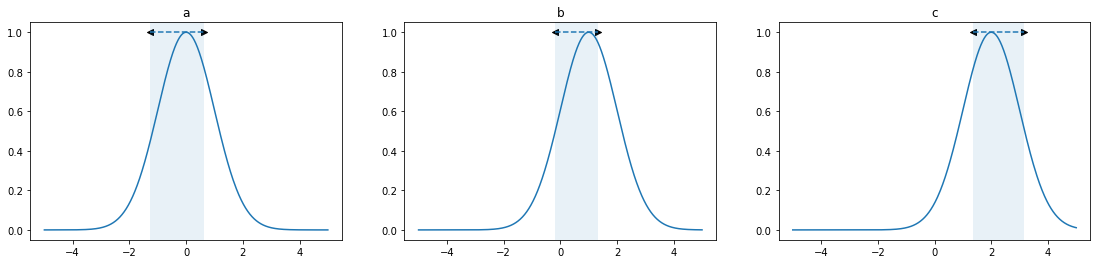

In [116]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals);

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
227,0.0035,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",6,8,14,7,3,35.0,0.628571,0.611771,7.685378


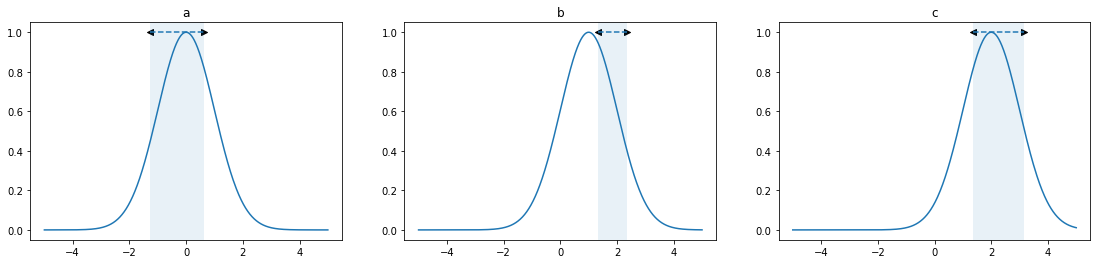

In [117]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals);

In [118]:
s_cols = []
tvalue_col = "t_value_fp_fn"
cols_show = ["support", "itemsets", metric, tvalue_col]
pd.set_option("max_colwidth", None)
sh = fpdiv.iloc[i:i+3][cols_show]
sh[tvalue_col] = sh[tvalue_col].round(1)
sh["support"] = sh["support"].round(2)
sh[metric] = sh[metric].round(3)
sh

,support,itemsets,d_error,t_value_fp_fn
227,0.0,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",0.612,7.7
238,0.0,"(a=[0.62917-1.76026], b=[-0.19413-1.34037], c=[1.37391-3.1627])",0.468,5.6
264,0.0,"(c=[0.29436-1.37354], b=[1.34048-2.36346], a=[-1.26793-0.62862])",0.400,4.3


### With generalization

In [119]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)
apply_generalization = True

FP_fm = extract_divergence_generalized(
    df_analysis,
    discretizations,
    generalization_dict,
    continuous_attributes,
    min_sup_divergence=min_sup_divergence,
    apply_generalization=True,
    true_class_name=pred_name,
    predicted_class_name=class_name,
    class_map=class_map,
    #target_name = target,
    FPM_type="fpgrowth",
    metrics_divergence = [metric],
    type_experiment = type_experiment,
    allow_overalp = False if type_experiment!="all_attributes" else True
)

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [120]:
FP_fm.sort_values(metric, ascending = False).head()

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
990,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885
844,0.0094,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",15,25,37,17,3,94.0,0.659574,0.642774,13.253050
1135,0.0035,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",6,8,14,7,3,35.0,0.628571,0.611771,7.685378
848,0.0092,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[1.37391-3.1627])",22,28,28,14,3,92.0,0.608696,0.591896,11.756597
671,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731


In [121]:
from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
fp_divergence_o=FP_Divergence(FP_fm, metric)
mean_outcome = FP_fm.loc[FP_fm["itemsets"]==frozenset()]["error"][0]
fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

v = mean_outcome*0.1
fpdiv_t = fp_divergence_o.getDivergence(th_redundancy=v).sort_values(fp_divergence_o.metric, ascending = False)

In [122]:
fp_divergence_o.getDivergence(th_redundancy=0).sort_values("length")

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
0,1.0000,(),4917,85,83,4915,0,10000.0,0.016800,0.000000,0.000000
1,0.6748,(a=<=1.76026),3310,83,79,3276,1,6748.0,0.024007,0.007207,3.195029
96,0.1000,(c=[-0.71298-0.2919]),490,3,2,505,1,1000.0,0.005000,-0.011800,3.958272
7,0.3670,(a=<=-1.26817),1824,12,6,1828,1,3670.0,0.004905,-0.011895,6.698952
74,0.1142,(a=[0.62917-1.76026]),556,20,11,555,1,1142.0,0.027145,0.010345,2.197269
...,...,...,...,...,...,...,...,...,...,...,...
650,0.0150,"(c=[-0.71298-0.2919], a=<=1.76026, b=[-0.19413-2.36346])",74,3,2,71,3,150.0,0.033333,0.016533,1.429402
327,0.0353,"(b=>=-0.19413, a=<=-1.26817, c=[1.37391-3.1627])",170,10,2,171,3,353.0,0.033994,0.017194,1.964876
1183,0.0029,"(a=[0.62917-1.76026], c=[0.29436-1.37354], b=>=2.36444)",16,1,0,12,3,29.0,0.034483,0.017683,1.096015
781,0.0107,"(a=[1.76093-2.74722], b=>=-0.19413, c=[1.37391-3.1627])",50,1,2,54,3,107.0,0.028037,0.011237,1.101686


In [123]:
print("Mean error", fpdiv.loc[0]["error"].round(7))
fpdiv_t

Mean error 0.0168


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
990,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885
844,0.0094,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",15,25,37,17,3,94.0,0.659574,0.642774,13.253050
1135,0.0035,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",6,8,14,7,3,35.0,0.628571,0.611771,7.685378
848,0.0092,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[1.37391-3.1627])",22,28,28,14,3,92.0,0.608696,0.591896,11.756597
671,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731
...,...,...,...,...,...,...,...,...,...,...,...
702,0.0133,"(b=[2.36444-3.41615], a=[-2.82109--1.26817])",66,0,0,67,2,133.0,0.000000,-0.016800,1.271193
745,0.0116,"(a=[0.62917-1.76026], c=[-0.71298-0.2919])",55,0,0,61,2,116.0,0.000000,-0.016800,0.990678
767,0.0110,"(b=[2.36444-3.41615], a=<=1.76026, c=>=3.16338)",46,0,0,64,3,110.0,0.000000,-0.016800,0.891027
778,0.0108,"(c=>=3.16338, b=>=2.36444, a=[-1.26793-0.62862])",44,0,0,64,3,108.0,0.000000,-0.016800,0.857739


In [124]:
fpdiv.head(10)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
990,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885
844,0.0094,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",15,25,37,17,3,94.0,0.659574,0.642774,13.253050
1135,0.0035,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",6,8,14,7,3,35.0,0.628571,0.611771,7.685378
848,0.0092,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[1.37391-3.1627])",22,28,28,14,3,92.0,0.608696,0.591896,11.756597
671,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731
988,0.0059,"(b=[1.34048-2.36346], c=[0.29436-3.1627], a=[-1.26793-0.62862])",12,11,21,15,3,59.0,0.542373,0.525573,8.279480
628,0.0158,"(a=[-1.26793-0.62862], c=[0.29436-3.1627], b=[-0.19413-2.36346])",37,34,51,36,3,158.0,0.537975,0.521175,13.241629
814,0.0099,"(b=[-0.19413-1.34037], c=[0.29436-3.1627], a=[-1.26793-0.62862])",25,23,30,21,3,99.0,0.535354,0.518554,10.479817
669,0.0144,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[0.29436-3.1627])",45,36,35,28,3,144.0,0.493056,0.476256,11.543995
1050,0.0051,"(b=[1.34048-2.36346], a=[-1.26793-1.76026], c=[1.37391-3.1627])",13,9,16,13,3,51.0,0.490196,0.473396,6.961481


In [125]:
if min_sup_divergence not in stats_tree:
    stats_tree[min_sup_divergence] = {}
stats_tree[min_sup_divergence]["generalized"] = fpdiv.iloc[0]

#### Top

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
990,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885


output/figures/artificial/artificial_gaussian_splits_sup_0.001_generalized.pdf


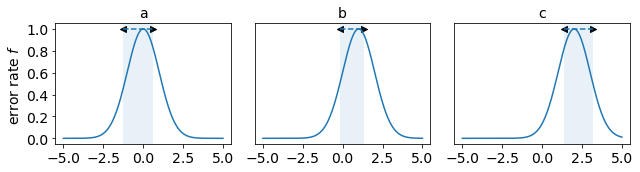

In [126]:
i = 0
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
type_gen = 'generalized' if apply_generalization else "base"
name_fig = f"{outfig_dir}/artificial_gaussian_splits_sup_{min_sup_divergence}_{type_gen}.pdf"
print(name_fig)
plot_attributes_split_gaussian(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals, \
                               ylabel = "error rate $f$" , name_fig = name_fig, save_fig = True);

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
844,0.0094,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",15,25,37,17,3,94.0,0.659574,0.642774,13.25305


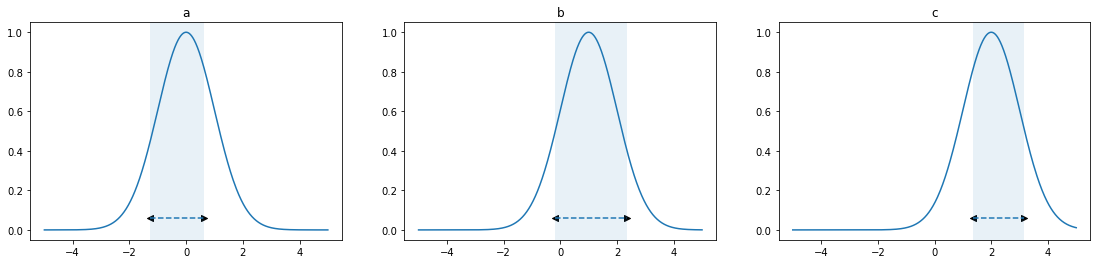

In [127]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g, g_attrs, min_max_vals);

In [128]:
errors = (df_analysis["true_class"]!=df_analysis["predicted_class"]).values.astype(int)

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
844,0.0094,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",15,25,37,17,3,94.0,0.659574,0.642774,13.25305


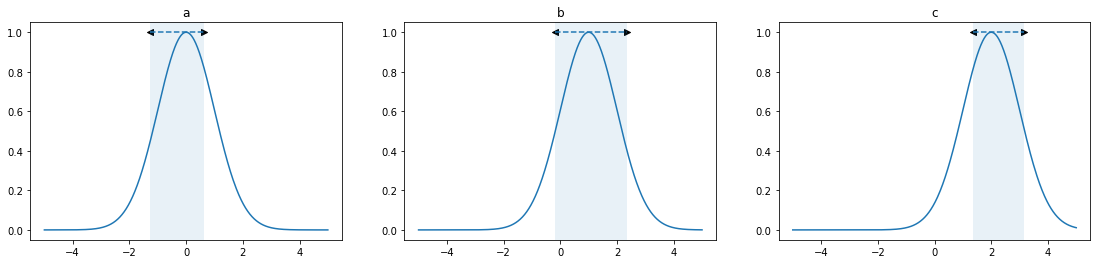

In [129]:
i = 1
display(fpdiv.iloc[i:i+1])

itemset = fpdiv.iloc[i]["itemsets"]
plot_attributes_split(df_analysis, attributes, itemset,  g_sc, g_attrs, min_max_vals);

In [130]:
s_cols = []
tvalue_col = "t_value_fp_fn"
cols_show = ["support", "itemsets", metric, tvalue_col]
pd.set_option("max_colwidth", None)
sh = fpdiv.iloc[i:i+3][cols_show]
sh[tvalue_col] = sh[tvalue_col].round(1)
sh["support"] = sh["support"].round(2)
sh[metric] = sh[metric].round(3)
sh

,support,itemsets,d_error,t_value_fp_fn
844,0.01,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",0.643,13.3
1135,0.00,"(a=[-1.26793-0.62862], b=[1.34048-2.36346], c=[1.37391-3.1627])",0.612,7.7
848,0.01,"(b=[-0.19413-1.34037], a=[-1.26793-1.76026], c=[1.37391-3.1627])",0.592,11.8


# Tree divergence results

In [131]:
min_sups = [0.005, 0.0075, 0.01, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]

In [132]:
stats_tree = {}

In [133]:
from utils_extract_divergence_generalized_ranking import (
    extract_divergence_generalized,
)
for min_sup_divergence in min_sups:
    for apply_generalization in [True, False]:
        if apply_generalization is True:
            gen_type = "generalized"
        else:
            gen_type = "base"
        FP_fm = extract_divergence_generalized(
            df_analysis,
            discretizations,
            generalization_dict,
            continuous_attributes,
            min_sup_divergence=min_sup_divergence,
            apply_generalization=apply_generalization,
            true_class_name=pred_name,
            predicted_class_name=class_name,
            class_map=class_map,
            FPM_type="fpgrowth",
            metrics_divergence = [metric],
            type_experiment = type_experiment,
            allow_overalp = False if type_experiment!="all_attributes" else True
        )
        from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
        fp_divergence_o=FP_Divergence(FP_fm, metric)
        fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

        if min_sup_divergence not in stats_tree:
            stats_tree[min_sup_divergence] = {}
        stats_tree[min_sup_divergence][gen_type] = fpdiv.iloc[0]

,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


,a,b,c,predicted_class,true_class
0,[-1.26793-0.62862],>=3.41622,[1.37391-3.1627],1.0,1.0
1,[0.62917-1.76026],<=-1.60971,<=-0.71354,0.0,0.0
2,<=-3.88783,>=3.41622,[0.29436-1.37354],1.0,1.0
3,[1.76093-2.74722],<=-1.60971,>=3.16338,0.0,0.0
4,>=2.74742,<=-1.60971,<=-0.71354,1.0,1.0
...,...,...,...,...,...
9995,[0.62917-1.76026],[-0.19413-1.34037],<=-0.71354,1.0,1.0
9996,[-1.26793-0.62862],<=-1.60971,[-0.71298-0.2919],1.0,1.0
9997,>=2.74742,<=-1.60971,<=-0.71354,0.0,0.0
9998,[-2.82109--1.26817],>=3.41622,[1.37391-3.1627],0.0,0.0


In [134]:
stats_tree.keys()

dict_keys([0.005, 0.0075, 0.01, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075])

# Discretization

In [135]:
def check_ranges_validity(dfI_discr_quantile, bins, continuous_attributes):
    for cont_attr in continuous_attributes:
        if len(dfI_discr_quantile[cont_attr].value_counts()) != bins:
            print(dict(dfI_discr_quantile[cont_attr].value_counts()))
            raise ValueError


In [164]:
i

0

## Quantile

### Varying supports

In [136]:
# DOTO not deterministic

In [137]:
from import_datasets import discretize
stats = {}

for bins in [2,3,4,5, 6, 7, 8, 9, 10]:
    dfI_discr = discretize(
        df_analysis, bins=bins, strategy="quantile", round_v = 3, adaptive=True, attributes = continuous_attributes
    )

    check_ranges_validity(dfI_discr, bins, continuous_attributes)

    # ### Extract divergence

    from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

    fp_diver = FP_DivergenceExplorer(
        dfI_discr,
        true_class_name = "true_class",
        predicted_class_name= "predicted_class",
    )
    for sup in min_sups:
        FP_fm = fp_diver.getFrequentPatternDivergence(
                        min_support=sup, metrics=[metric]
                    )
        from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
        fp_divergence_o=FP_Divergence(FP_fm, metric)
        fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)
        if sup not in stats:
            stats[sup] = {}
        stats[sup][bins] = fpdiv.iloc[i][metric]

from copy import deepcopy
quantile_stats2 = deepcopy(stats)


0.005  -  5


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
197,0.0071,"(c=(0.977-2.942], b=(-1.016-0.988], a=(-0.957-1.011])",23,19,13,16,3,71.0,0.450704,0.433904,7.519539


[('generalized', 0.6611661016949152), ('base', 0.6611661016949152)]
0.0075  -  4


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
113,0.0147,"(c=(-0.014-2.412], b=(-0.013-2.497], a=(0.029-2.509])",51,16,28,52,3,147.0,0.29932,0.28252,7.601081


[('generalized', 0.6427744680851063), ('base', 0.2123666666666666)]
0.01  -  4


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
113,0.0147,"(c=(-0.014-2.412], b=(-0.013-2.497], a=(0.029-2.509])",51,16,28,52,3,147.0,0.29932,0.28252,7.601081


[('generalized', 0.5496335664335664), ('base', 0.2123666666666666)]
0.02  -  6


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
40,0.0288,"(b=(-0.013-1.631], c=(1.611-3.283])",113,32,27,116,2,288.0,0.204861,0.188061,7.989504


Attribute a not in the itemset
[('generalized', 0.4573379310344827), ('base', 0.2123666666666666)]
0.025  -  6


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
40,0.0288,"(b=(-0.013-1.631], c=(1.611-3.283])",113,32,27,116,2,288.0,0.204861,0.188061,7.989504


Attribute a not in the itemset
[('generalized', 0.29748571428571424), ('base', 0.2123666666666666)]
0.03  -  5


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
86,0.0372,"(c=(0.977-2.942], a=(-0.957-1.011])",162,43,30,137,2,372.0,0.196237,0.179437,8.779169


Attribute b not in the itemset
[('generalized', 0.29748571428571424), ('base', 0.20271219512195116)]
0.04  -  5


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
16,0.0436,"(b=(0.988-3.026], a=(-0.957-1.011])",197,33,27,179,2,436.0,0.137615,0.120815,7.383105


Attribute c not in the itemset
[('generalized', 0.24941923937360178), ('base', 0.045295730918499366)]
0.05  -  4


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
42,0.0618,"(c=(-0.014-2.412], b=(-0.013-2.497])",235,45,43,295,2,618.0,0.142395,0.125595,8.96381


Attribute a not in the itemset
[('generalized', 0.2287445544554455), ('base', 0.045295730918499366)]
0.06  -  4


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
42,0.0618,"(c=(-0.014-2.412], b=(-0.013-2.497])",235,45,43,295,2,618.0,0.142395,0.125595,8.96381


Attribute a not in the itemset
[('generalized', 0.15556662106703145), ('base', 0.045295730918499366)]
0.07  -  3


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
24,0.111,"(b=(-1.678-1.631], a=(-1.623-1.685])",518,51,52,489,2,1110.0,0.092793,0.075993,8.685861


Attribute c not in the itemset
[('generalized', 0.15556662106703145), ('base', 0.045295730918499366)]
0.075  -  3


,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
24,0.111,"(b=(-1.678-1.631], a=(-1.623-1.685])",518,51,52,489,2,1110.0,0.092793,0.075993,8.685861


Attribute c not in the itemset
[('generalized', 0.15402785808147168), ('base', 0.045295730918499366)]


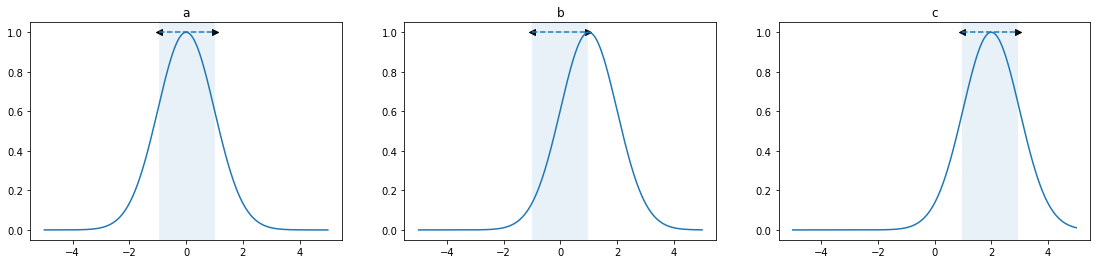

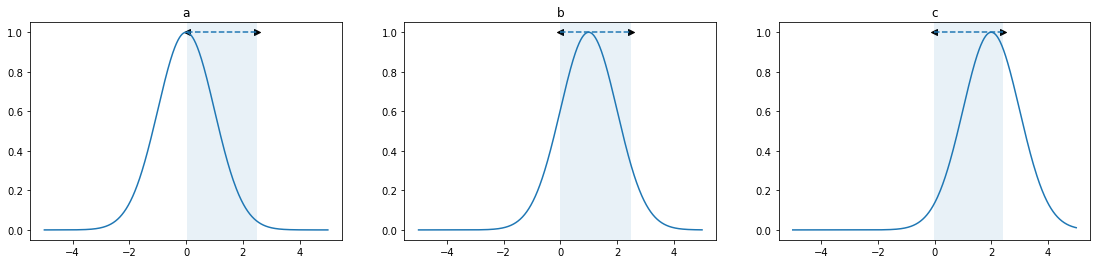

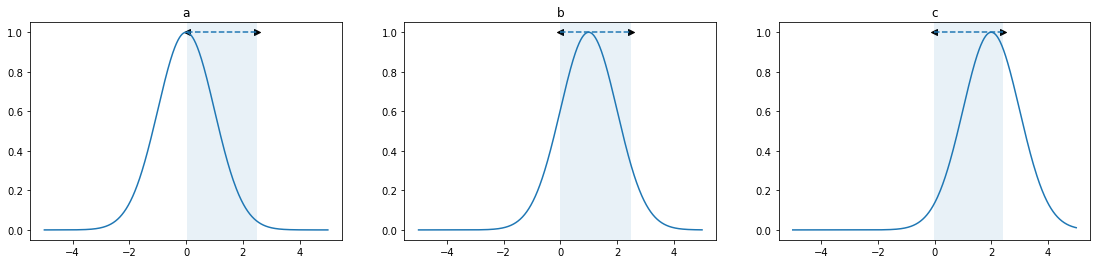

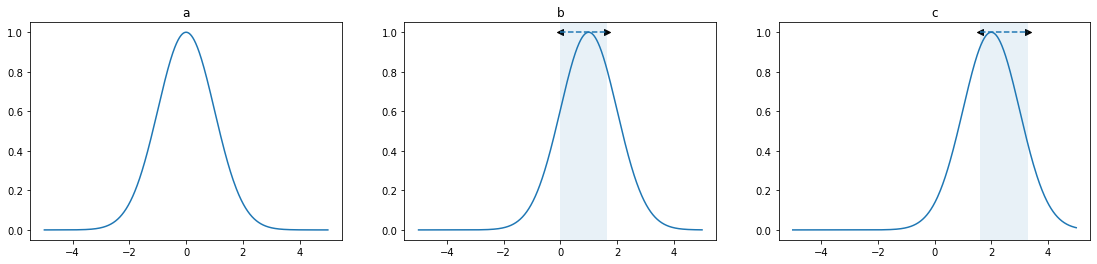

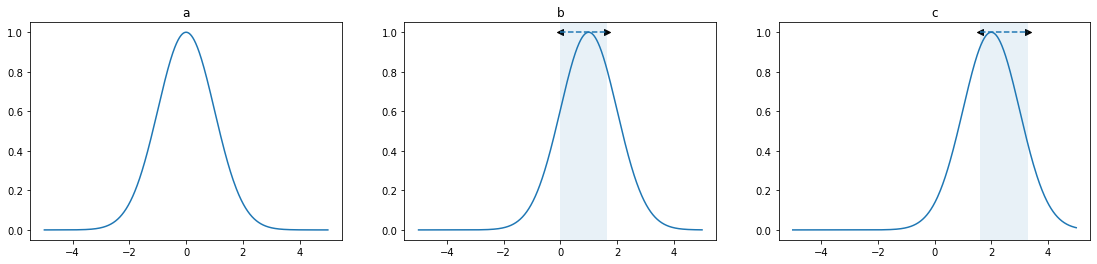

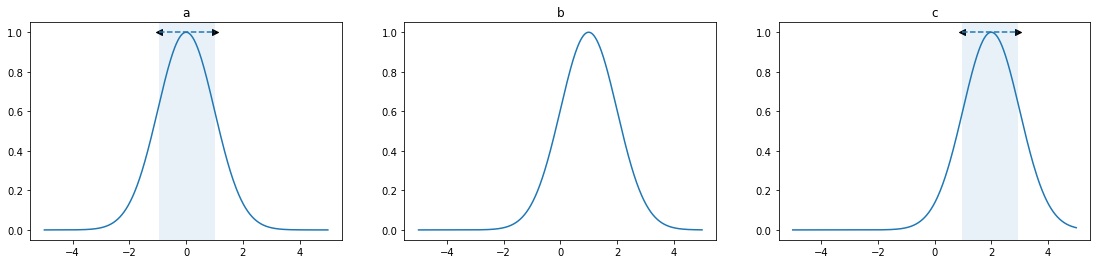

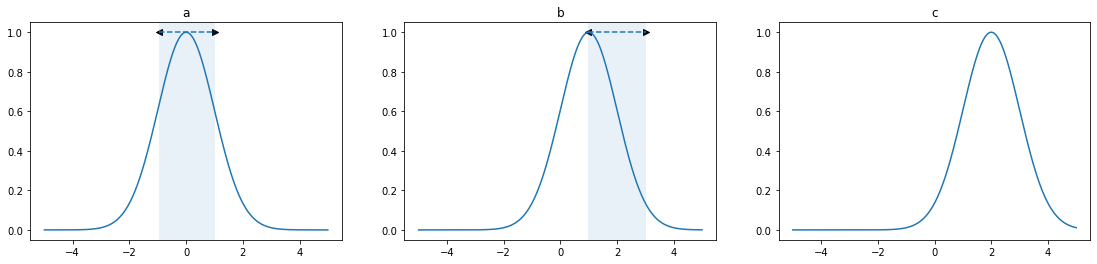

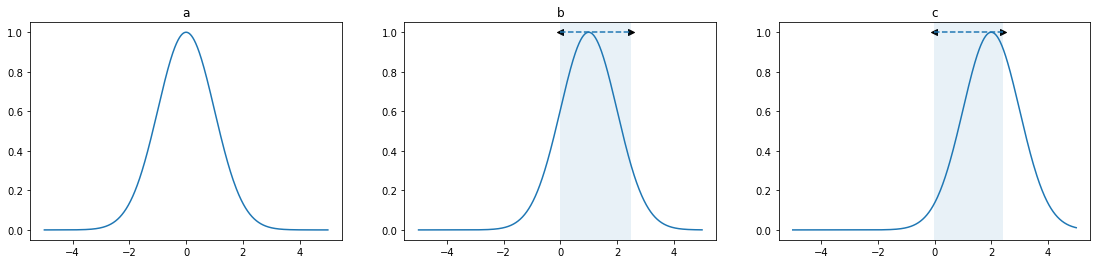

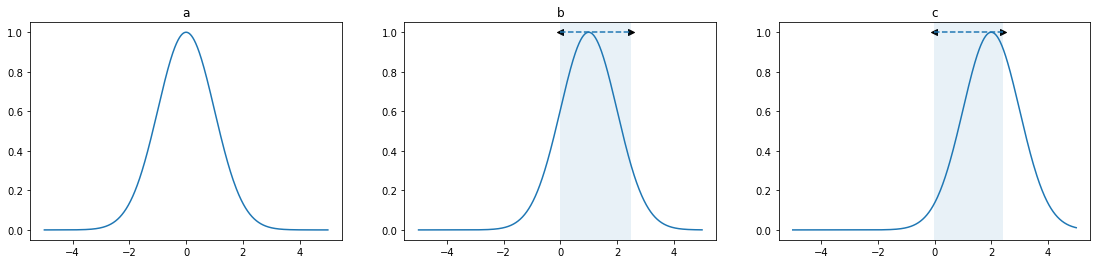

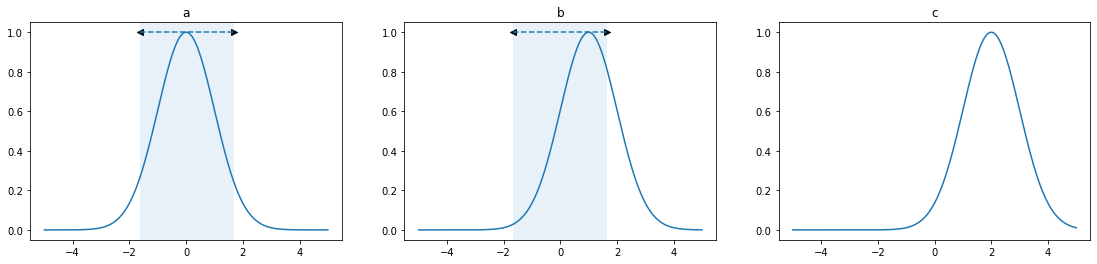

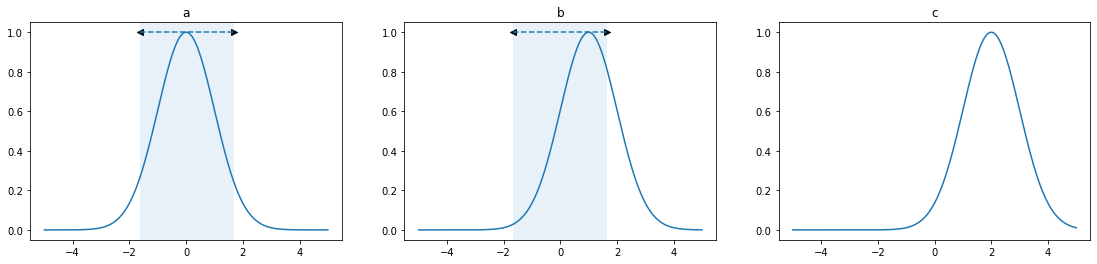

In [138]:
from operator import itemgetter
quantile_stats = {}
for sup in stats:
    best = sorted(stats[sup].items(), key=lambda item: item[1], reverse = True)[0]

    bins = best[0]

    print(sup , " - ", bins)

    from import_datasets import discretize
    dfI_discr = discretize(
        df_analysis, bins=bins, strategy="quantile", round_v = 3, adaptive=True, attributes = continuous_attributes
    )

    from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

    fp_diver = FP_DivergenceExplorer(
        dfI_discr,
        true_class_name = "true_class",
        predicted_class_name= "predicted_class",
    )

    FP_fm = fp_diver.getFrequentPatternDivergence(
                    min_support=sup, metrics=["d_error"]
                )
    from divexplorer_generalized_ranking.FP_Divergence import FP_Divergence
    fp_divergence_o=FP_Divergence(FP_fm, metric)
    fpdiv = fp_divergence_o.getDivergence(th_redundancy=0).sort_values(fp_divergence_o.metric, ascending = False)

    i = 0

    display(fpdiv.iloc[i:i+1])

    itemset = fpdiv.iloc[i]["itemsets"]
    plot_attributes_split(df_analysis, attributes, itemset, g_sc, g_attrs, min_max_vals);
    quantile_stats[sup] = fpdiv.iloc[i]
    print([(g, v[metric]) for g, v in stats_tree[sup].items()])

In [139]:
dfs = []
for sup in stats_tree:
    for t in stats_tree[sup]:
        df_i = pd.DataFrame(stats_tree[sup][t]).T
        df_i["sup_tree"] = sup
        df_i["type"] = f"tree_{t}"
        dfs.append(df_i)
dfs = pd.concat(dfs)
cols = list(dfs.columns)
dfs

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn,sup_tree,type
988,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885,0.0050,tree_generalized
181,0.0059,"(b=[-0.19413-1.34037], c=[1.37391-3.1627], a=[-1.26793-0.62862])",9,17,23,10,3,59.0,0.677966,0.661166,10.987885,0.0050,tree_base
840,0.0094,"(a=[-1.26793-0.62862], c=[1.37391-3.1627], b=[-0.19413-2.36346])",15,25,37,17,3,94.0,0.659574,0.642774,13.25305,0.0075,tree_generalized
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825,0.0075,tree_base
673,0.0143,"(a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])",35,37,44,27,3,143.0,0.566434,0.549634,13.366731,0.0100,tree_generalized
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825,0.0100,tree_base
477,0.0232,"(a=[-1.26793-1.76026], c=[0.29436-3.1627], b=[-0.19413-2.36346])",67,50,60,55,3,232.0,0.474138,0.457338,14.033032,0.0200,tree_generalized
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825,0.0200,tree_base
304,0.0385,"(c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])",133,57,64,131,3,385.0,0.314286,0.297486,12.629937,0.0250,tree_generalized
55,0.0288,"(b=[-0.19413-1.34037], c=[1.37391-3.1627])",110,35,31,112,2,288.0,0.229167,0.212367,8.654825,0.0250,tree_base


In [140]:
q_dfs = []
for sup in quantile_stats:
    df_i = pd.DataFrame(quantile_stats[sup]).T
    df_i["sup_tree"] = sup
    q_dfs.append(df_i)
q_dfs = pd.concat(q_dfs)
cols = list(q_dfs.columns)
q_dfs["type"] = "quantile"

In [141]:
df_all = pd.concat([dfs, q_dfs])
df_all = df_all.sort_values(["sup_tree", "type"], ascending = False)
df_all

,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn,sup_tree,type
143,0.0761,"(a=[-1.26793-1.76026], b=>=-0.19413, c=>=0.29436)",316,63,67,315,3,761.0,0.170828,0.154028,11.295429,0.0750,tree_generalized
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478,0.0750,tree_base
24,0.111,"(b=(-1.678-1.631], a=(-1.623-1.685])",518,51,52,489,2,1110.0,0.092793,0.075993,8.685861,0.0750,quantile
151,0.0731,"(c=[0.29436-3.1627], b=[-0.19413-2.36346])",276,62,64,329,2,731.0,0.172367,0.155567,11.145781,0.0700,tree_generalized
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478,0.0700,tree_base
24,0.111,"(b=(-1.678-1.631], a=(-1.623-1.685])",518,51,52,489,2,1110.0,0.092793,0.075993,8.685861,0.0700,quantile
151,0.0731,"(c=[0.29436-3.1627], b=[-0.19413-2.36346])",276,62,64,329,2,731.0,0.172367,0.155567,11.145781,0.0600,tree_generalized
9,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478,0.0600,tree_base
42,0.0618,"(c=(-0.014-2.412], b=(-0.013-2.497])",235,45,43,295,2,618.0,0.142395,0.125595,8.96381,0.0600,quantile
234,0.0505,"(a=<=1.76026, c=[0.29436-3.1627], b=[-0.19413-2.36346])",169,61,63,212,3,505.0,0.245545,0.228745,11.982265,0.0500,tree_generalized


### Comparison

In [142]:
df_all[['sup_tree', 'type', 'support', 'itemsets', 'd_error', 't_value_fp_fn' ]]
df_all_t = df_all.set_index(['sup_tree', 'type'])
df_all_t[['support', 'itemsets', 'd_error', 't_value_fp_fn']]

support  \
sup_tree type                       
0.0750   tree_generalized  0.0761   
         tree_base         0.1546   
         quantile           0.111   
0.0700   tree_generalized  0.0731   
         tree_base         0.1546   
         quantile           0.111   
0.0600   tree_generalized  0.0731   
         tree_base         0.1546   
         quantile          0.0618   
0.0500   tree_generalized  0.0505   
         tree_base         0.1546   
         quantile          0.0618   
0.0400   tree_generalized  0.0447   
         tree_base         0.1546   
         quantile          0.0436   
0.0300   tree_generalized  0.0385   
         tree_base         0.0328   
         quantile          0.0372   
0.0250   tree_generalized  0.0385   
         tree_base         0.0288   
         quantile          0.0288   
0.0200   tree_generalized  0.0232   
         tree_base         0.0288   
         quantile          0.0288   
0.0100   tree_generalized  0.0143   
         tree_base         0.0288   
         quantile          0.0147   
0.0075   tree_generalized  0.0094   
         tree_base         0.0288   
         quantile          0.0147   
0.0050   tree_generalized  0.0059   
         tree_base         0.0059   
         quantile          0.0071   

                                                                                   itemsets  \
sup_tree type                                                                                 
0.0750   tree_generalized                 (a=[-1.26793-1.76026], b=>=-0.19413, c=>=0.29436)   
         tree_base                                                   (b=[-0.19413-1.34037])   
         quantile                                      (b=(-1.678-1.631], a=(-1.623-1.685])   
0.0700   tree_generalized                        (c=[0.29436-3.1627], b=[-0.19413-2.36346])   
         tree_base                                                   (b=[-0.19413-1.34037])   
         quantile                                      (b=(-1.678-1.631], a=(-1.623-1.685])   
0.0600   tree_generalized                        (c=[0.29436-3.1627], b=[-0.19413-2.36346])   
         tree_base                                                   (b=[-0.19413-1.34037])   
         quantile                                      (c=(-0.014-2.412], b=(-0.013-2.497])   
0.0500   tree_generalized           (a=<=1.76026, c=[0.29436-3.1627], b=[-0.19413-2.36346])   
         tree_base                                                   (b=[-0.19413-1.34037])   
         quantile                                      (c=(-0.014-2.412], b=(-0.013-2.497])   
0.0400   tree_generalized          (a=[-1.26793-1.76026], b=>=-0.19413, c=[0.29436-3.1627])   
         tree_base                                                   (b=[-0.19413-1.34037])   
         quantile                                       (b=(0.988-3.026], a=(-0.957-1.011])   
0.0300   tree_generalized         (c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])   
         tree_base                               (a=[-1.26793-0.62862], c=[1.37391-3.1627])   
         quantile                                       (c=(0.977-2.942], a=(-0.957-1.011])   
0.0250   tree_generalized         (c=>=0.29436, a=[-1.26793-1.76026], b=[-0.19413-2.36346])   
         tree_base                               (b=[-0.19413-1.34037], c=[1.37391-3.1627])   
         quantile                                       (b=(-0.013-1.631], c=(1.611-3.283])   
0.0200   tree_generalized  (a=[-1.26793-1.76026], c=[0.29436-3.1627], b=[-0.19413-2.36346])   
         tree_base                               (b=[-0.19413-1.34037], c=[1.37391-3.1627])   
         quantile                                       (b=(-0.013-1.631], c=(1.611-3.283])   
0.0100   tree_generalized  (a=[-1.26793-1.76026], c=[1.37391-3.1627], b=[-0.19413-2.36346])   
         tree_base                               (b=[-0.19413-1.34037], c=[1.37391-3.1627])   
         quantile                     (c=(-0.014-2.412], b=(-0.013-2.4

In [143]:
df_all[['sup_tree', 'type', 'support', 'itemsets', 'd_error', 't_value_fp_fn' ]]
df_all_t = df_all.set_index(['type', 'sup_tree'])
df_all_t

,,support,itemsets,tn,fp,fn,tp,length,support_count,error,d_error,t_value_fp_fn
type,sup_tree,,,,,,,,,,,
tree_generalized,0.0750,0.0761,"(a=[-1.26793-1.76026], b=>=-0.19413, c=>=0.29436)",316,63,67,315,3,761.0,0.170828,0.154028,11.295429
tree_base,0.0750,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
quantile,0.0750,0.111,"(b=(-1.678-1.631], a=(-1.623-1.685])",518,51,52,489,2,1110.0,0.092793,0.075993,8.685861
tree_generalized,0.0700,0.0731,"(c=[0.29436-3.1627], b=[-0.19413-2.36346])",276,62,64,329,2,731.0,0.172367,0.155567,11.145781
tree_base,0.0700,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
quantile,0.0700,0.111,"(b=(-1.678-1.631], a=(-1.623-1.685])",518,51,52,489,2,1110.0,0.092793,0.075993,8.685861
tree_generalized,0.0600,0.0731,"(c=[0.29436-3.1627], b=[-0.19413-2.36346])",276,62,64,329,2,731.0,0.172367,0.155567,11.145781
tree_base,0.0600,0.1546,(b=[-0.19413-1.34037]),687,52,44,763,1,1546.0,0.062096,0.045296,7.274478
quantile,0.0600,0.0618,"(c=(-0.014-2.412], b=(-0.013-2.497])",235,45,43,295,2,618.0,0.142395,0.125595,8.96381


## Plot results

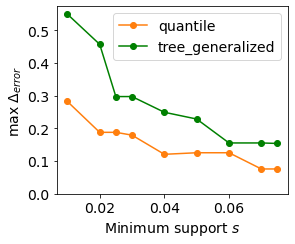

In [160]:
results = {}
results["quantile"] = q_dfs.groupby("sup_tree")["d_error"].apply(float).to_dict()#.to_dict()
results["tree_generalized"] = dfs.loc[dfs["type"]=="tree_generalized"].groupby("sup_tree")["d_error"].apply(float).to_dict()#.to_dict()
#results["tree_base"] = dfs.loc[dfs["type"]=="tree_base"].groupby("sup_tree")["d_error"].apply(float).to_dict()#.to_dict()
colors = {"quantile": 'C1', 'tree_generalized': 'g'}
sup_show = [0.01, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]

fig, ax = plt.subplots(figsize= (4.2,3.5))
for k, r in results.items():
    r_plot = {k:v for k,v in r.items() if k in sup_show}
    
    ax.plot(list(r_plot.keys()), list(r_plot.values()), label = k, marker = "o", c=colors[k])
ax.set_xlabel("Minimum support $s$")
ax.set_ylabel("max $\Delta_{error}$")
ax.set_ylim((0))
plt.legend(fontsize = 14);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
     ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
    
plt.tight_layout()
plt.savefig(f"{outfig_dir}/artificial_gaussian_discretization_comparison.pdf");

# Plots

In [145]:
def show_splits_axes_2(attr, ax, ranges, min_max_vals, h = 2, eps=0, color = "black", linestyle = '--', label = None):
    if attr not in ranges:
        print(f"Attribute {attr} not in the itemset")
        return ax
    start_v, end_v = ranges[attr]
    if start_v is None:
        start_v = min_max_vals[attr][0]
    if end_v is None:
        end_v = min_max_vals[attr][1]
    
    ax.vlines(x = start_v, ymin=0, ymax=1, linestyle = linestyle, colors=color)
    ax.vlines(x = end_v, ymin=0, ymax=1, linestyle = linestyle, colors=color)
#    end_v, alpha=0.1)
    ax.hlines(y=h, xmin=start_v, xmax=end_v, linestyle = linestyle, colors=color, label=label)
    ax.scatter([start_v + eps ], [h], marker = '<',  c=color)
    ax.scatter([end_v - eps], [h], marker = '>' ,  c=color)
    return ax
        

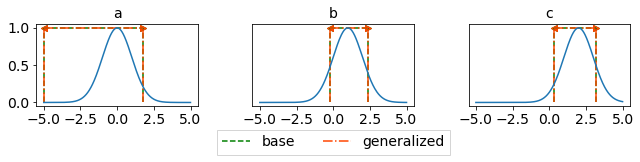

In [146]:
sup = 0.025

target_vals = g_sc
ranges_1 = get_ranges_from_itemset(stats_tree[0.05]["generalized"].itemsets)
ranges_2 = get_ranges_from_itemset(stats_tree[0.05]["generalized"].itemsets)
eps = 0
h = max(target_vals)+eps
fig, axs = plt.subplots(1,len(attributes), figsize = (9,2.5))
for e, attribute in enumerate(attributes):
    axs[e] = plot_normal_attr(df_analysis[attribute].values, axs[e], target_vals, g_attrs[e], plot_points = False)
    l1 = "base" 
    l2 = "generalized" 
    show_splits_axes_2(attribute, axs[e], ranges_1, min_max_vals, h, eps = eps, color = "green", label=l1)
    show_splits_axes_2(attribute, axs[e], ranges_2, min_max_vals, h, eps = eps, color = "orangered", linestyle = "-.", label=l2)
    axs[e].set_title(attribute, fontsize = 14);
    if e>0:
        axs[e].set_yticks([])
    for item in ([axs[e].title, axs[e].xaxis.label, axs[e].yaxis.label] +
             axs[e].get_xticklabels() + axs[e].get_yticklabels()):
        item.set_fontsize(14)
plt.subplots_adjust(wspace = .025)
labels = {}
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    for id_l in range(0, len(l)):
        if l[id_l] not in labels:
            labels[l[id_l]] = h[id_l]
#axs[0].legend(labels.values(), labels.keys(), loc='upper center', bbox_to_anchor=(1, 1.05))
axs[1].legend(labels.values(), labels.keys(),loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize = 14)
#plt.title(attribute);
plt.tight_layout()
#fig.suptitle(f'$s$={sup}', fontsize=16)
plt.savefig(f"{outfig_dir}/artificial_gaussian_splits_sup_{sup}.pdf");

Attribute a not in the itemset
Attribute c not in the itemset
Sup:0.05. base 0.045
Sup:0.05. generalized 0.229
Attribute a not in the itemset
Sup:0.025. base 0.212
Sup:0.025. generalized 0.297


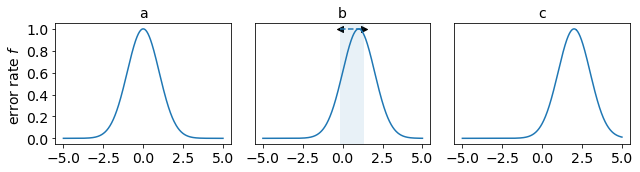

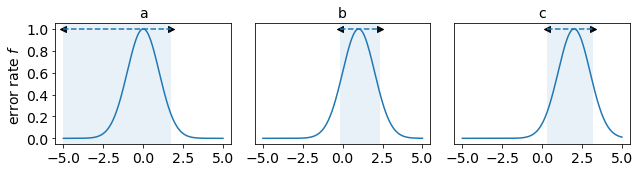

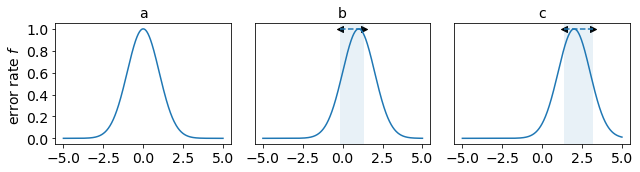

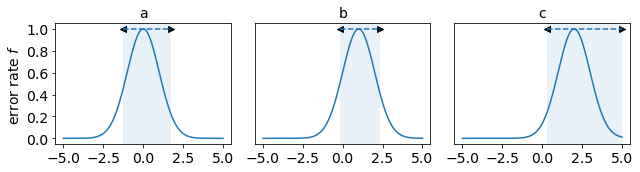

In [147]:
for sup in [0.05, 0.025]:
    for type_gen in ["base", "generalized"]:
        target_vals = g_sc
        ranges_1 = get_ranges_from_itemset(stats_tree[sup][type_gen].itemsets)
        eps = 0
        h = max(target_vals)+eps
        fig, axs = plt.subplots(1,len(attributes), figsize = (9,2.5))
        for e, attribute in enumerate(attributes):
            axs[e] = plot_normal_attr(df_analysis[attribute].values, axs[e], target_vals, g_attrs[e], plot_points = False)
            l1 = "base" 
            l2 = "generalized" 
            show_splits_axes(attribute, axs[e], ranges_1, min_max_vals, h, eps = eps)
            axs[e].set_title(attribute, fontsize = 14);
            if e>0:
                axs[e].set_yticks([])
            for item in ([axs[e].title, axs[e].xaxis.label, axs[e].yaxis.label] +
                     axs[e].get_xticklabels() + axs[e].get_yticklabels()):
                item.set_fontsize(14)
        plt.subplots_adjust(wspace = .025)
        labels = {}
        for ax in axs:
            h, l = ax.get_legend_handles_labels()
            for id_l in range(0, len(l)):
                if l[id_l] not in labels:
                    labels[l[id_l]] = h[id_l]

        axs[0].set_ylabel("error rate $f$")
        #axs[0].legend(labels.values(), labels.keys(), loc='upper center', bbox_to_anchor=(1, 1.05))
        #axs[1].legend(labels.values(), labels.keys(),loc='upper center', 
        #             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize = 14)
        #plt.title(attribute);
        plt.tight_layout()
        #fig.suptitle(f'$s$={sup}', fontsize=16)
        plt.savefig(f"{outfig_dir}/artificial_gaussian_splits_sup_{sup}_{type_gen}.pdf");
        print(f"Sup:{sup}. {type_gen} {stats_tree[sup][type_gen][metric]:.3f}")

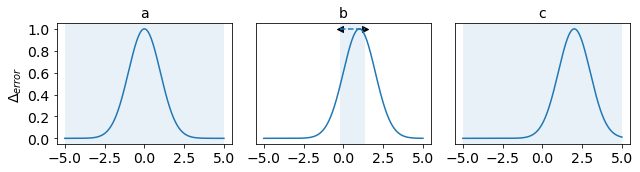

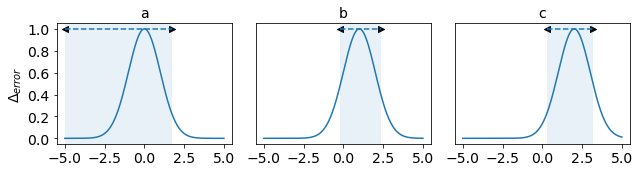

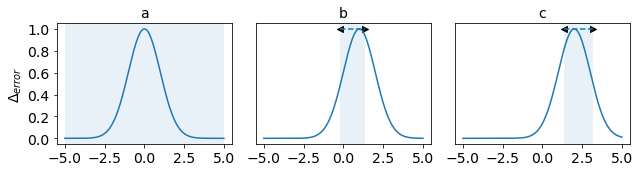

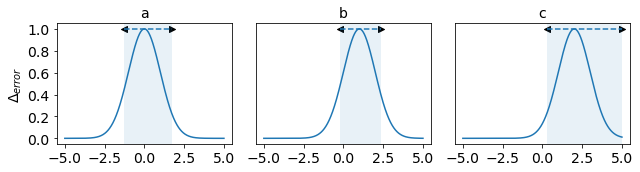

In [148]:
for sup in [0.05, 0.025]:
    for type_gen in ["base", "generalized"]:
        target_vals = g_sc
        ranges_1 = get_ranges_from_itemset(stats_tree[sup][type_gen].itemsets)
        eps = 0
        h = max(target_vals)+eps
        fig, axs = plt.subplots(1,len(attributes), figsize = (9,2.5))
        for e, attribute in enumerate(attributes):
            axs[e] = plot_normal_attr(df_analysis[attribute].values, axs[e], target_vals, g_attrs[e], plot_points = False)
            l1 = "base" 
            l2 = "generalized" 
            show_splits_axes(attribute, axs[e], ranges_1, min_max_vals, h, eps = eps, show_all_if_non = True)
            axs[e].set_title(attribute, fontsize = 14);
            if e>0:
                axs[e].set_yticks([])
            for item in ([axs[e].title, axs[e].xaxis.label, axs[e].yaxis.label] +
                     axs[e].get_xticklabels() + axs[e].get_yticklabels()):
                item.set_fontsize(14)
        plt.subplots_adjust(wspace = .025)
        labels = {}
        for ax in axs:
            h, l = ax.get_legend_handles_labels()
            for id_l in range(0, len(l)):
                if l[id_l] not in labels:
                    labels[l[id_l]] = h[id_l]

        axs[0].set_ylabel("$\Delta_{error}$")
        #axs[0].legend(labels.values(), labels.keys(), loc='upper center', bbox_to_anchor=(1, 1.05))
        #axs[1].legend(labels.values(), labels.keys(),loc='upper center', 
        #             bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=3, fontsize = 14)
        #plt.title(attribute);
        plt.tight_layout()
        #fig.suptitle(f'$s$={sup}', fontsize=16)
        plt.savefig(f"{outfig_dir}/artificial_gaussian_splits_sup_{sup}_{type_gen}_v2.pdf");

In [149]:
def plot_attributes_split(df_vals, attributes, itemset, target_vals, g_attrs, min_max_vals, verbose = False, plot_points = False):
    
    ranges = get_ranges_from_itemset(itemset)
    if verbose:
        print("Ranges", ranges)
    eps = 0
    h = max(target_vals)+eps
    
    max_viz = 5
    if len(attributes)> max_viz:
        # Show at most max_viz attributes
        attributes = attributes[:max_viz]
    
    fig, axs = plt.subplots(1,len(attributes), figsize = (19,4))
    for e, attribute in enumerate(attributes):
        axs[e] = plot_normal_attr(df_vals[attribute].values, axs[e], target_vals, g_attrs[e], plot_points = plot_points)
        show_splits_axes(attribute, axs[e], ranges, min_max_vals, h, eps = eps)
        axs[e].set_title(attribute);
    return fig

# Discretization Slice Finder - DELETE

In [161]:
def check_ranges_validity(dfI_discr_quantile, bins, continuous_attributes):
    for cont_attr in continuous_attributes:
        if len(dfI_discr_quantile[cont_attr].value_counts()) != bins:
            print(dict(dfI_discr_quantile[cont_attr].value_counts()))
            raise ValueError


In [163]:
from sklearn.metrics import log_loss
import functools

from sklearn.utils.multiclass import unique_labels
y_true = df_analysis["true_class"].values
y_pred_prob = df_analysis["predicted_class"].values
classes=unique_labels(y_true)

y_p = list(map(functools.partial(np.expand_dims, axis=0), y_true))
y = list(map(functools.partial(np.expand_dims, axis=0), y_pred_prob))
loss_list_FP= np.array(list(map(functools.partial(log_loss, labels=classes), y, y_p)))

## Tree

In [195]:
from utils_discretize_df import (
    discretize_df_via_discretizations,
)

df_discreted_d = discretize_df_via_discretizations(
    df_analysis,
    discretizations,
    allow_overalp = False
)

In [196]:
stats = {}
n_bin_sf = 10
k = 30
i = 0


from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

for effect_size in [0.4, 0.6, 0.8, 1, 1.2]:
    print(effect_size)
    sf = SliceFinder((df_discreted_d[continuous_attributes], df_discreted_d["true_class"]), n_bin_sf, loss_list_FP)
    recommendations = sf.find_slice(degree=degree, max_workers=max_workers, k = 50, epsilon = effect_size)  

    recom_df=getRecommendationsDf(recommendations)


    recom_df=recom_df.drop_duplicates()
    recom_df = recom_df.sort_values("effect_size", ascending=False)

    if effect_size not in stats:
        stats[effect_size] = {}
    if recom_df.shape[0]>0:
        stats[effect_size][bins] = recom_df.iloc[i]["effect_size"]
    else:
        stats[effect_size][bins] = 0
        
from copy import deepcopy
tree_stats_sf = deepcopy(stats)

0.4
degree 1
degree : 1, recommended slices : 4
degree 2
degree : 2, recommended slices : 1
degree 3
degree : 3, recommended slices : 0
0.6
degree 1
degree : 1, recommended slices : 3
degree 2
degree : 2, recommended slices : 3
degree 3
degree : 3, recommended slices : 0
0.8
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 10
degree 3
degree : 3, recommended slices : 26
1
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 10
degree 3
degree : 3, recommended slices : 21
1.2
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 9
degree 3
degree : 3, recommended slices : 18


## Quantile

### Varying effect_size

In [136]:
# DOTO not deterministic

In [172]:
from import_datasets import discretize
stats = {}
n_bin_sf = 10
k = 30
i = 0
for bins in [2,3,4,5, 6, 7, 8, 9, 10]:
    dfI_discr = discretize(
        df_analysis, bins=bins, strategy="quantile", round_v = 3, adaptive=True, attributes = continuous_attributes
    )

    check_ranges_validity(dfI_discr, bins, continuous_attributes)

    # ### Extract divergence

    from divexplorer_generalized.FP_DivergenceExplorer import FP_DivergenceExplorer

    for effect_size in [0.4, 0.6, 0.8, 1, 1.2]:
        sf = SliceFinder((dfI_discr[continuous_attributes], dfI_discr["true_class"]), n_bin_sf, loss_list_FP)
        recommendations = sf.find_slice(degree=degree, max_workers=max_workers, k = 50, epsilon = effect_size)  

        recom_df=getRecommendationsDf(recommendations)

        
        recom_df=recom_df.drop_duplicates()
        recom_df = recom_df.sort_values("effect_size", ascending=False)

        if effect_size not in stats:
            stats[effect_size] = {}
        if recom_df.shape[0]>0:
            stats[effect_size][bins] = recom_df.iloc[i]["effect_size"]
        else:
            stats[effect_size][bins] = 0
        
from copy import deepcopy
quantile_stats_sf = deepcopy(stats)


degree 1
degree : 1, recommended slices : 2
degree 2
degree : 2, recommended slices : 0
degree 3
degree : 3, recommended slices : 0
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 1
degree 3
degree : 3, recommended slices : 4
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 0
degree 3
degree : 3, recommended slices : 0
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 0
degree 3
degree : 3, recommended slices : 0
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended slices : 0
degree 3
degree : 3, recommended slices : 0
degree 1
degree : 1, recommended slices : 2
degree 2
degree : 2, recommended slices : 0
degree 3
degree : 3, recommended slices : 0
degree 1
degree : 1, recommended slices : 1
degree 2
degree : 2, recommended slices : 1
degree 3
degree : 3, recommended slices : 0
degree 1
degree : 1, recommended slices : 0
degree 2
degree : 2, recommended

In [186]:
from operator import itemgetter
best_scores_sf = {"quantile": {}}
for effect_size in stats:
    best = sorted(stats[effect_size].items(), key=lambda item: item[1], reverse = True)[0]

    bins = best[0]
    best_scores_sf['quantile'][effect_size] = best
best_scores_sf

{'quantile': {0.4: (6, 0.8405639377579577),
  0.6: (8, 1.6729640287940564),
  0.8: (6, 2.8482881116902528),
  1: (6, 3.5943339597997),
  1.2: (8, 6.045577833496983)}}

In [197]:
from operator import itemgetter
best_scores_sf["tree_base"] = {}
for effect_size in tree_stats_sf:
    best = sorted(tree_stats_sf[effect_size].items(), key=lambda item: item[1], reverse = True)[0]

    bins = best[0]
    best_scores_sf['tree_base'][effect_size] = best
best_scores_sf

{'quantile': {0.4: (6, 0.8405639377579577),
  0.6: (8, 1.6729640287940564),
  0.8: (6, 2.8482881116902528),
  1: (6, 3.5943339597997),
  1.2: (8, 6.045577833496983)},
 'tree_base': {0.4: (8, 0.7891215624293658),
  0.6: (8, 1.552148762883671),
  0.8: (8, 3.153967935479611),
  1: (8, 3.153967935479611),
  1.2: (8, 3.3375925791411687)}}

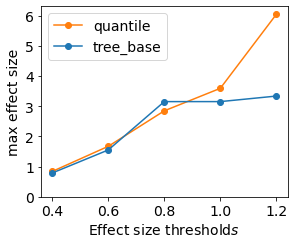

In [199]:
colors = {"quantile": 'C1', 'tree_base': 'C0'}

fig, ax = plt.subplots(figsize= (4.2,3.5))
for k, r in best_scores_sf.items():
    r_plot = {k:v[1] for k,v in r.items() }
    ax.plot(list(r_plot.keys()), list(r_plot.values()), label = k, marker = "o", c=colors[k])
ax.set_xlabel("Effect size threshold$s$")
ax.set_ylabel("max effect size")
ax.set_ylim((0))
plt.legend(fontsize = 14);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
     ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
    
plt.tight_layout()
#plt.savefig(f"{outfig_dir}/artificial_gaussian_discretization_comparison.pdf");

## Plot results

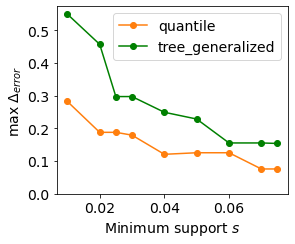

In [160]:
results = {}
results["quantile"] = q_dfs.groupby("sup_tree")["d_error"].apply(float).to_dict()#.to_dict()
results["tree_generalized"] = dfs.loc[dfs["type"]=="tree_generalized"].groupby("sup_tree")["d_error"].apply(float).to_dict()#.to_dict()
#results["tree_base"] = dfs.loc[dfs["type"]=="tree_base"].groupby("sup_tree")["d_error"].apply(float).to_dict()#.to_dict()
colors = {"quantile": 'C1', 'tree_generalized': 'g'}
sup_show = [0.01, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.075]

fig, ax = plt.subplots(figsize= (4.2,3.5))
for k, r in results.items():
    r_plot = {k:v for k,v in r.items() if k in sup_show}
    
    ax.plot(list(r_plot.keys()), list(r_plot.values()), label = k, marker = "o", c=colors[k])
ax.set_xlabel("Minimum support $s$")
ax.set_ylabel("max $\Delta_{error}$")
ax.set_ylim((0))
plt.legend(fontsize = 14);
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
     ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
    
plt.tight_layout()
plt.savefig(f"{outfig_dir}/artificial_gaussian_discretization_comparison.pdf");

# test

In [60]:
# import useful modules
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

# fetch titanic dataset
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X.drop(['cabin', 'boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)

# define pipeline
cat_cols = X.select_dtypes("category").columns
num_cols = X.select_dtypes("number").columns

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(random_state=42))])

# training
clf.fit(X, y)

# predict on training data
y_proba = clf.predict_proba(X)[:, 1] # score of being a '1'

# compute element-wise log loss (the lower, the better)
eps = 1e-15
y_proba = np.clip(y_proba, eps, 1 - eps)
y = y.astype(int)

training_errors = - (y * np.log(y_proba) + (1 - y) * np.log(1 - y_proba))


In [61]:
# import sliceline and binning class
from optbinning import ContinuousOptimalBinning

# dataset before prediction
X_trans = pd.DataFrame(clf[0].transform(X), columns=clf[0].get_feature_names_out())

# `age` and `fare` have to be bined
columns_to_bin = ["num__age", "num__fare"]

optimal_binner = ContinuousOptimalBinning()

X_trans[columns_to_bin] = np.array(
    [
        optimal_binner.fit_transform(X_trans[col], training_errors, metric="bins") for col in columns_to_bin
    ]
).T

# fitting sliceline
sf = SliceLine(
    alpha = 0.95,
    k = 1,
    max_l = X_trans.shape[1],
    min_sup = 1,
    verbose = True
)

sf.fit(X_trans, training_errors)

DEBUG:sliceline_master.sliceline.slicefinder:Dropping 0/38 features below min_sup = 1.
DEBUG:sliceline_master.sliceline.slicefinder:Initial top-K: count=1, max=0.413802, min=0.413802
DEBUG:sliceline_master.sliceline.slicefinder:Level 2:
DEBUG:sliceline_master.sliceline.slicefinder: -- generated paired slice candidates: 38 -> 451
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/sliceline_master/sliceline/slicefinder.py:331: RuntimeWarning: invalid value encountered in true_divide
  (slice_errors / slice_sizes) / self.average_error_ - 1
/Users/eliana/Projects/hierarchical-subgroup-exploration-private/sliceline_master/sliceline/slicefinder.py:332: RuntimeWarning: divide by zero encountered in true_divide
  ) - (1 - self.alpha) * (n_row_x_encoded / slice_sizes - 1)
DEBUG:sliceline_master.sliceline.slicefinder: -- valid slices after eval: 410/451
DEBUG:sliceline_master.sliceline.slicefinder: -- top-K: count=1, max=0.565950, min=0.565950


Eliana input_x [[1.0 '(-inf, 32.25)' 0.0 ... 0.0 0.0 1.0]
 [1.0 '(-inf, 32.25)' 1.0 ... 0.0 0.0 1.0]
 [1.0 '(-inf, 32.25)' 1.0 ... 0.0 0.0 1.0]
 ...
 [3.0 '(-inf, 32.25)' 0.0 ... 1.0 0.0 0.0]
 [3.0 '(-inf, 32.25)' 0.0 ... 1.0 0.0 0.0]
 [3.0 '(-inf, 32.25)' 0.0 ... 0.0 0.0 1.0]]
Eliana x_encoded   (0, 0)	1.0
  (0, 3)	1.0
  (0, 7)	1.0
  (0, 14)	1.0
  (0, 27)	1.0
  (0, 29)	1.0
  (0, 30)	1.0
  (0, 32)	1.0
  (0, 34)	1.0
  (0, 37)	1.0
  (1, 0)	1.0
  (1, 3)	1.0
  (1, 8)	1.0
  (1, 16)	1.0
  (1, 27)	1.0
  (1, 28)	1.0
  (1, 31)	1.0
  (1, 32)	1.0
  (1, 34)	1.0
  (1, 37)	1.0
  (2, 0)	1.0
  (2, 3)	1.0
  (2, 8)	1.0
  (2, 16)	1.0
  (2, 27)	1.0
  :	:
  (1306, 28)	1.0
  (1306, 31)	1.0
  (1306, 33)	1.0
  (1306, 34)	1.0
  (1306, 36)	1.0
  (1307, 2)	1.0
  (1307, 3)	1.0
  (1307, 7)	1.0
  (1307, 14)	1.0
  (1307, 22)	1.0
  (1307, 28)	1.0
  (1307, 31)	1.0
  (1307, 33)	1.0
  (1307, 34)	1.0
  (1307, 36)	1.0
  (1308, 2)	1.0
  (1308, 3)	1.0
  (1308, 7)	1.0
  (1308, 14)	1.0
  (1308, 22)	1.0
  (1308, 28)	1.0
  (130

DEBUG:sliceline_master.sliceline.slicefinder:Level 3:
DEBUG:sliceline_master.sliceline.slicefinder: -- generated paired slice candidates: 410 -> 2282
DEBUG:sliceline_master.sliceline.slicefinder: -- valid slices after eval: 2237/2282
DEBUG:sliceline_master.sliceline.slicefinder: -- top-K: count=1, max=0.682603, min=0.682603
DEBUG:sliceline_master.sliceline.slicefinder:Level 4:
DEBUG:sliceline_master.sliceline.slicefinder: -- generated paired slice candidates: 2237 -> 6396
DEBUG:sliceline_master.sliceline.slicefinder: -- valid slices after eval: 6325/6396
DEBUG:sliceline_master.sliceline.slicefinder: -- top-K: count=2, max=0.705890, min=0.705890
DEBUG:sliceline_master.sliceline.slicefinder:Level 5:
DEBUG:sliceline_master.sliceline.slicefinder: -- generated paired slice candidates: 6325 -> 10255
DEBUG:sliceline_master.sliceline.slicefinder: -- valid slices after eval: 10212/10255
DEBUG:sliceline_master.sliceline.slicefinder: -- top-K: count=9, max=0.705890, min=0.705890
DEBUG:sliceline_m

Slicefinder(alpha=0.95, max_l=10, min_sup=1)

In [62]:
X_trans

,num__pclass,num__age,num__sibsp,num__parch,num__fare,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S
0,1.0,"(-inf, 32.25)",0.0,0.0,"[90.54, inf)",1.0,0.0,0.0,0.0,1.0
1,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",0.0,1.0,0.0,0.0,1.0
2,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",1.0,0.0,0.0,0.0,1.0
3,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",0.0,1.0,0.0,0.0,1.0
4,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"(-inf, 32.25)",1.0,0.0,"[7.89, 19.02)",1.0,0.0,1.0,0.0,0.0
1305,3.0,"(-inf, 32.25)",1.0,0.0,"[7.89, 19.02)",1.0,0.0,1.0,0.0,0.0
1306,3.0,"(-inf, 32.25)",0.0,0.0,"(-inf, 7.89)",0.0,1.0,1.0,0.0,0.0
1307,3.0,"(-inf, 32.25)",0.0,0.0,"(-inf, 7.89)",0.0,1.0,1.0,0.0,0.0


In [ ]:
pd.DataFrame(sf.top_slices_, columns=sf.feature_names_in_, index=sf.get_feature_names_out())


In [92]:
X_trans

,num__pclass,num__age,num__sibsp,num__parch,num__fare,cat__sex_female,cat__sex_male,cat__embarked_C,cat__embarked_Q,cat__embarked_S
0,1.0,"(-inf, 32.25)",0.0,0.0,"[90.54, inf)",1.0,0.0,0.0,0.0,1.0
1,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",0.0,1.0,0.0,0.0,1.0
2,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",1.0,0.0,0.0,0.0,1.0
3,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",0.0,1.0,0.0,0.0,1.0
4,1.0,"(-inf, 32.25)",1.0,2.0,"[90.54, inf)",1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"(-inf, 32.25)",1.0,0.0,"[7.89, 19.02)",1.0,0.0,1.0,0.0,0.0
1305,3.0,"(-inf, 32.25)",1.0,0.0,"[7.89, 19.02)",1.0,0.0,1.0,0.0,0.0
1306,3.0,"(-inf, 32.25)",0.0,0.0,"(-inf, 7.89)",0.0,1.0,1.0,0.0,0.0
1307,3.0,"(-inf, 32.25)",0.0,0.0,"(-inf, 7.89)",0.0,1.0,1.0,0.0,0.0


In [95]:
sf.

0.14262975213717055